# Analyzing Job Description Data: MBA VS Data Scientist

## Introduction

As technology has permeated through industry, the rise of data science and machine learning has led to many breakthroughs, innovations and discoveries as to how companies can shape and execute business strategy.  The data scientist has thus become an indespensible part of the business.  Contrast this meteoric rise to that of a more traditional business leader, the MBA.  While these individuals are skilled at specific aspects of running a business such as management, marketing, operations or finance, there exists an ever growing opportunity to enhance and empower such business expertise with data and scientifically-backed analysis and tools.

We have entered a time where the gulf between science and business management is becoming ever more narrow.  Companies need decisive leaders backed by a technical rigor and an innovative embrace.  Ergo, we need both MBAs and Data Scientists to lead our businesses in 2017 and beyond.

### Objective

In this analysis, we will explore the similarities and differences between the roles of MBA and Data Scientist as revealed through a comprehensive look at current trends in the job markets as well as the underlying job description text for both roles.

We will also develop, test and tweak machine learning models with the aim of accurately classifying job postings as either MBA or Data Science based on the text of the given descriptions.

We will accomplish these two objectives via sequential steps outlined below.
* Visualizing and tabulating the types of companies, cities and job titles represented by each job category
* Training various classification models to determine the job category by job description
* Combining individual machine learning models with powerful ensemble techniques to achieve greater accuracy
* Exploring the classifications of the best model and digging deeper into the types of jobs that are hardest to classify.

### What is the ultimate goal?
While ....the overall objective is to explore, demonstrate and deploy sophisticated machine learning models for accurate text classification.

Potential parties who might include might benefit from this analysis:
* MBAs interested in pursuing roles related to data science.
* Data scienstists interested in purusing roles related to business management and administration.
* Managers seeking employees who fill the requirements of either (or both) role categories.


### Technical Aim

In this analysis, we will be leveraging the powerful data analysis and machine learning libraries of Python.  All analysis is coded and provided below as such.  The intent is to provide a fully reproducible analysis to enable feedback, discussions and suggestions.  The following versions of Python and respective packages are listed below:

In [1]:
import platform
platform.architecture()

('64bit', '')

In [2]:
platform.system()

'Linux'

In [3]:
platform.release()

'4.10.0-35-generic'

In [4]:
platform.version()

'#39-Ubuntu SMP Wed Sep 13 07:46:59 UTC 2017'

In [5]:
import sys
print(sys.version)

3.5.3 (default, Jul 21 2017, 01:02:33) 
[GCC 6.3.0 20170406]


In [6]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
print(pd.__name__," ",pd.__version__)

pandas   0.20.3


In [7]:
import nltk
print(nltk.__name__," ",nltk.__version__)

nltk   3.2.4


In [8]:
import numpy as np
print(np.__name__," ",np.__version__)

numpy   1.13.1


In [9]:
import re
print(re.__name__," ",re.__version__)

re   2.2.1


In [10]:
import sklearn
print(sklearn.__name__," ",sklearn.__version__)

sklearn   0.18.2


In [11]:
import matplotlib
print(matplotlib.__name__," ",matplotlib.__version__)

matplotlib   2.0.2


In [12]:
import geopy
print(geopy.__name__," ",geopy.__version__)

geopy   1.11.0


In [13]:
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
print(scipy.__name__," ",scipy.__version__)

scipy   0.19.1


### Data Source: Indeed.com

Job description data was collected from Indeed.com for most of the large cities in the United States.  For collection purposes, the Indeed.com job search API was utilized over a period of _____ in mid 2017.  A notebook outlining the methogology and code for collecting and storing the data on a daily basis can be found here _____ for those who are interested.

In [21]:
df_combined = pd.read_csv("https://raw.githubusercontent.com/CollierKing/Classify_Jobs_Indeed/master/indeed_jobs.csv",encoding = "ISO-8859-1")

Lets subset an equal amount of non-overlaping job postings from each dataframe. We have 50k postings in each category to explore.

In [22]:
df_combined.groupby('category').size()

category
data_science    50000
mba             50000
dtype: int64

In [27]:
# dir = "/home/collier/Dropbox/Skills/Python/Projects/Jobs/Classify_Jobs_Indeed/"
# df_combined.to_csv(dir+"indeed_jobs.csv")

Lets take a quick glance at the data. We have several columns of interest such as Job Location, Company, Job Title and 'Snippet.' Snippet is a truncated text field with the description for the particular job.

Looking at the cumulative sum of jobs that were posted in each category, we see that MBA jobs initially outpaced Data Science jobs, but during the month of August 2017, the number of Data Science jobs that were posted began to spike.

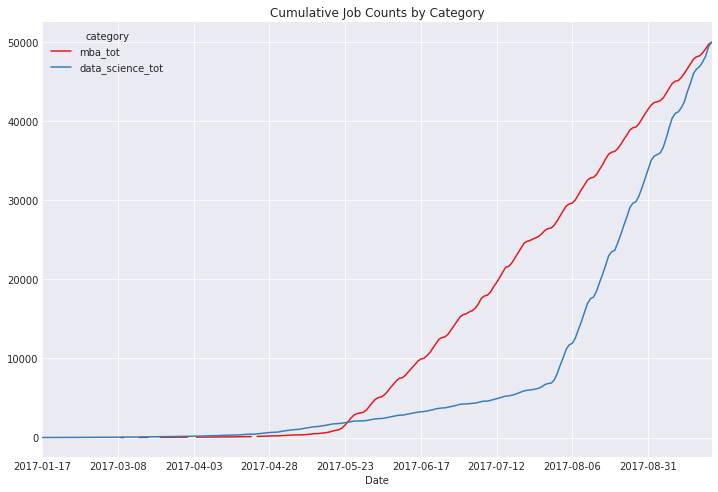

In [30]:
pivoted_counts = pd.pivot_table(df_combined, index=['Date'], 
                            columns='category', values='Job_Key',aggfunc="size")
pivoted_counts.reset_index(inplace=True)
pivoted_counts['data_science_tot'] = np.cumsum(pivoted_counts['data_science'])
pivoted_counts['mba_tot'] = np.cumsum(pivoted_counts['mba'])
pivoted_counts.index = pivoted_counts['Date']
pivoted_counts = pivoted_counts[['mba_tot','data_science_tot']]
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
current_palette_7 = sns.color_palette("Set1", 2)
sns.set_palette(current_palette_7)
plt.figure();
pivoted_counts.plot(figsize=(12,8),title="Cumulative Job Counts by Category");

## Data Pre-processing

### Cleaning Text

Now we will begin to look at the actual text in the job descriptions. This text will later become the classification features of our models. In order to not 'game' the classification process, we will remove some overly descriptive terms from the job descriptions, which might tip the algorithm as to the actual category its classifying.  These terms include "MBA", "Data Scientist" and like terms.

In [112]:
df_data_sci = df_combined[df_combined['category']=="data_science"]
df_mba = df_mba[df_mba['category']=="mba"]

df_data_sci_clean = df_data_sci
df_mba_clean = df_mba

In [113]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/collier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [114]:
# add custom stopwords
stop_plus = ["mba",
             "m.b.a",
             "masters of business administration",
             "masters in business administration",
             "data scientist","data science",
             "science"]
# combine stopword lists
stop = stop + stop_plus

In [115]:
df_data_sci_clean['Snippet'] = df_data_sci_clean['Snippet'].apply(preprocessor)
df_data_sci_clean['Snippet'] = df_data_sci_clean['Snippet'].apply(lambda x: [item for item in str.split(x) if item not in stop])
df_mba_clean['Snippet'] = df_mba_clean['Snippet'].apply(preprocessor)
df_mba_clean['Snippet'] = df_mba_clean['Snippet'].apply(lambda x: [item for item in str.split(x) if item not in stop])

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [116]:
df_data_sci_clean['Snippet'] = df_data_sci_clean['Snippet'].apply(lambda x: ' '.join(x))
df_mba_clean['Snippet'] = df_mba_clean['Snippet'].apply(lambda x: ' '.join(x))

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [117]:
df_combined_clean = pd.concat([df_data_sci_clean,df_mba_clean])

### Tokenizing Text

In order to make the text from our job descriptions into useful model features, we have to aggregate and summarise distinct terms in a meaningful way.  To accomplish this, we will transform our job description data into a **Term Frequency–Inverse Document Frequency (TF-IDF)** matrix.  

TF-IDF is a popular word weighting scheme which seeks to define how important a word is to a document in a collection or corpus. Under TF-IDF, words that occur frequently within a given document (or job description in our case), but do not occur frequently within the entire corpos of words, will receive a larger weighting as they are deamed to be more important in relaying meaning behind the given document. 

You can read more about the TF-IDF methogology and structure in scikit-learn [here:](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

We will use scikit-learn's tfidftransformer and countvectorizor classes below for this purpose.

WIP - define max/min DF & ngram range

**Parameters used:**
* ngram_range:
    * This parameter instructs the tokenizer as to how many different combinations of words to use (ex: unigram, bigram, trigram, etc).
* max_df:
    * Instructs the algorithm to ignore terms that have a document frequency proportion above the given threshold (ex: 80%).
* min_df:
    * Instructs the algorithm to ignore terms that have a document frequency proportion below the given threshold (ex: 20%).

## Exploratory Data Analysis

In the following section we will explore the data by looking at the geographical distribution of jobs as well as the types of jobs in companies and cities.  We will group and summarise the data into meaningful tables and visualations with Pandas and Seaborn. We will also utilize some unsupervised learning techniques to uncover more about the relationships in our text data.

### Unsupervised Techniques

#### K-means Clustering

**K-means** is a popular algorithm for clustering.  **Clustering** is a technique that allows us to uncover groups of related data points as defined by being more similar to each other than they are to other data points. The metric we use for 'similarity' is actually the level of distance between two points, specifically the **squared Euclidean distance**.

The K-means algorithm is essentially an optimization solver, which interates over the data and creates **centroids** which are the average of similar points within a given cluster.  The goal is to minimize the **within-cluster sum of squared errors (SSE)** or **"distortion"** of the data points within the cluster. This is accomplished after the either the specified number of iterations is passed or convergence is reached.

In this analysis, we will fit the clusters based on the text of the job descriptions and then visualize the clusters across different categories such as city, company and job title.

You can read more about K-means [here](https://en.wikipedia.org/wiki/K-means_clustering).

#### Multi-Dimensional Scaling

**Multi-Dimensional Scaling (MDS)** is a non-linear dimensionality reduction algorithm.  It is often used to visualize levels of similarity or disparity among observations in a dataset.  This is useful when dealing with high dimensional data (such as the text data in our sample) as we can condense the dimensions into 2, into a visual plane.  Other similar dimensionality reduction techniques include **Principal Component Analysis (PCA)** and **Factor Analysis**.

You can read more about MDS [here](https://en.wikipedia.org/wiki/Multidimensional_scaling).

### Top Words by Category

To begin our exploratory data analysis, let's first take a look at the top terms in each category (Data Science & MBA).

* For Data Science jobs, words like 'data','computer','engineering' and 'design' are frequent.

* For MBA jobs, words like 'develop','business', 'management' and 'analysis' are near the top.

In [34]:
from collections import Counter
result = Counter(" ".join(df_data_sci_clean["Snippet"].values.tolist()).split(" "))
word_counts_data_sci = pd.DataFrame.from_dict(result, orient='index').reset_index()
word_counts_data_sci.columns = ['data_sci_words','count']
word_counts_data_sci['pct'] = round(100 * (word_counts_data_sci['count']/sum(word_counts_data_sci['count'])),2)

word_counts_data_sci.sort_values("count",ascending=False,inplace=True)
word_counts_data_sci.reset_index(inplace=True)
result = Counter(" ".join(df_mba_clean["Snippet"].values.tolist()).split(" "))
word_counts_mba = pd.DataFrame.from_dict(result, orient='index').reset_index()
word_counts_mba.columns = ['mba_words','count']
word_counts_mba['pct'] = round(100 * (word_counts_mba['count']/sum(word_counts_mba['count'])),2)
word_counts_mba.sort_values("count",ascending=False,inplace=True)
word_counts_mba.reset_index(inplace=True)
word_counts_all = pd.concat([word_counts_data_sci, word_counts_mba],axis=1)
del word_counts_all['index']
word_counts_all.head(10)

,data_sci_words,count,pct,mba_words,count,pct
0,data,28199,1.55,develop,29332.0,1.61
1,experience,25925,1.43,business,26461.0,1.46
2,degree,25248,1.39,field,17207.0,0.95
3,computer,24351,1.34,analysis,16889.0,0.93
4,engineering,24101,1.33,degree,16498.0,0.91
5,design,23950,1.32,experience,15418.0,0.85
6,technical,22978,1.27,management,15321.0,0.84
7,field,22099,1.22,related,12650.0,0.70
8,related,21324,1.17,financial,12205.0,0.67
9,develop,17373,0.96,technical,11980.0,0.66


#### Skill Keywords

One topic of great interest in this analysis is what the distribution of skill-specific keywords looks like across different categories.  We will investigate the number of skill keywords across locations, companies and job titles later, but now let's take a look at the overall picture across our two job categories.

To determine what skill-specific key words to look for, we turn to top tag lists www.stackexchange.com, maintainer of www.stackoverflow.com and a popular source for skill-specific questions and conversations. The notebook containing the query used for this purpose can be found here [https://github.com/CollierKing/stackexchange_keywords] WIP.

To obtain skill keywords specific to both MBA and Data Science, we took the top tags from the following domain-specific sites from StackExchange:
* Economics: https://economics.stackexchange.com/
* AI: https://ai.stackexchange.com/
* Product Management: https://pm.stackexchange.com/
* Quantitative Finance: https://quant.stackexchange.com/
* Startups: https://startups.stackexchange.com/
* Computer Science: https://cs.stackexchange.com/
* Statistics: https://stats.stackexchange.com/

We also pulled the top listed tags from stackoverflow here[https://data.stackexchange.com/stackoverflow/csv/903268]

In [139]:
keywords = pd.read_csv("https://raw.githubusercontent.com/CollierKing/stackexchange_keywords/master/stack_exchange_keywords.csv",header=None)
keywords.columns = ["index","keywords"]
keywords.drop_duplicates(subset="keywords",keep="last",inplace=True)
keywords.reset_index(inplace=True)
del keywords["index"]
del keywords["level_0"]

We have a collection just over 50K skill words, however we are only going to use the top 250.

In [140]:
keywords["cat_count"] = ""
keywords["loc_count"] = ""
keywords["company_count"] = ""
keywords["jobtitle_count"] = ""

In [141]:
for idx,word in keywords.iterrows():
    if idx > 250:
        continue
    else:
        try:
            sub = df_combined_clean[df_combined_clean['Snippet'].str.contains(word[0],na=False)]
            cat_list = dict(sub.groupby("category").size())
            loc_list = dict(sub.groupby("Location").size())
            company_list = dict(sub.groupby("Company").size())
            jobtitle_list = dict(sub.groupby("Job_Title").size())

            keywords.set_value(idx,"cat_count",cat_list)
            keywords.set_value(idx,"loc_count",loc_list)
            keywords.set_value(idx,"company_count",company_list)
            keywords.set_value(idx,"jobtitle_count",jobtitle_list)
        except:
            continue
    if idx % 50 == 0:
        print(idx/len(keywords))
keywords.to_csv(dir+"ski")

0.0
0.000998462367953
0.00199692473591
0.00299538710386
0.00399384947181
0.00499231183977


In [142]:
dir

'/home/collier/Dropbox/Skills/Python/Projects/Jobs/Classify_Jobs_Indeed/'

### Job Locations

Jobs from a wide variety of employment locations were obtained in the data collection process. Lets visualize the distribution of location of jobs geographically. We pulled the latitude/longitude coordinates of each city and then plot them on a map of the U.S. The notebook containing the code with this query is here["https://github.com/CollierKing/city_geolocator] WIP

In [37]:
city_list = pd.read_csv("https://raw.githubusercontent.com/CollierKing/city_geolocator/master/city_list.csv")

We will also calculate the relative prevalence of either MBA or Data Science jobs in a given location.  This will be calculated as a ratio of the numer of Data Science jobs to total jobs.  Below is a glance at the city dataframe.

In [38]:
# calculate ratios of data science to total jobs by city
city_list_ratio = pd.DataFrame(df_combined
                               .groupby(['Location','category'])
                               .size()).reset_index().sort_values(0,ascending=False)
city_list_ratio = city_list_ratio.pivot(index='Location', columns='category', values=0).reset_index()
city_list_ratio['DS_%'] = city_list_ratio['data_science']/(city_list_ratio['data_science']+\
                                                              city_list_ratio['mba'])
city_list_ratio['City'] = city_list_ratio['Location']
# city_list_ratio.sort_values('DS_ratio',ascending=False)
city_list2 = city_list.merge(city_list_ratio,how="inner",on="City")
city_list2['DS_%'] = city_list2['DS_%'].fillna(0)
city_list2['DS_%'] = round(city_list2['DS_%'],3)
city_list2['total'] = city_list2['data_science']+city_list2['mba']
city_list2.sort_values("total",ascending=False,inplace=True)
city_list2 = city_list2.head(500)
city_list2.sort_values("total",ascending=True,inplace=True)
city_list2.reset_index(inplace=True)

In [39]:
city_list2.head(2)

,index,Unnamed: 0,City,Location_x,lon,lat,Location_y,data_science,mba,DS_%,total
0,457,458,"Brighton, MA","(42.3500971, -71.1564423)",42.350097,-71.156442,"Brighton, MA",5.0,8.0,0.385,13.0
1,337,338,"New Rochelle, NY","(40.9115386, -73.7826363)",40.911539,-73.782636,"New Rochelle, NY",2.0,11.0,0.154,13.0


#### Geographic Distribution of Jobs

Lets plot the locations of the top 500 cities in our dataset as determined by total jobs. <span style="color:blue"> Blue </span> shapes represent cities with more than 60% of the posted jobs belonging to the data science category while <span style="color:red"> Red </span> shapes represent towns with more than 60% jobs as MBA.  Towns where between 40-60% of jobs are in either category are colored <span style="color:purple"> Purple </span>.

In [526]:
import folium
#create map of united states
map_osm = folium.Map(location=[39.50,-98.35], zoom_start=5)

In [527]:
#loop through city coordinates and plot city points
for idx, point in city_list2.iterrows():
    if idx > 500:
        break
    else:
        x = float(point['lon'])
        y = float(point['lat'])

        if point['DS_%'] >= 0.0 and point['DS_%'] < 0.4:
            folium.RegularPolygonMarker([x,y], popup=str(point['City'])+": DS %: "+str(round(point['DS_%']*100,3))+"%, Job Count: "+str(point['total']),
                          fill_color='red',number_of_sides=6,radius=10).add_to(map_osm)

        elif point['DS_%'] >= 0.4 and point['DS_%'] < 0.6:
            folium.RegularPolygonMarker([x,y], popup=str(point['City'])+": DS %: "+str(round(point['DS_%']*100,3))+"%, Job Count: "+str(point['total']),
                          fill_color='purple',number_of_sides=6,radius=10).add_to(map_osm)

        elif point['DS_%'] >= 0.6 and point['DS_%'] <= 1:
            folium.RegularPolygonMarker([x,y], popup=str(point['City'])+": DS %: "+str(round(point['DS_%']*100,3))+"%, Job Count: "+str(point['total']),
                          fill_color='blue',number_of_sides=6,radius=10).add_to(map_osm)

In [528]:
map_osm

#### Top Locations by Category

If we take a look at jobs across job categories and locations, we see that New York, Chicago, San Francisco and Seattle are the top spots for both data science and MBA jobs in terms of the number of raw postings.  

In [529]:
ds_job_locs = pd.DataFrame((df_data_sci
     .groupby('Location')
     .count()
     .sort_values('Company',ascending=False)['Company']
     .reset_index()))
mba_job_locs = pd.DataFrame((df_mba
     .groupby('Location')
     .count()
     .sort_values('Company',ascending=False)['Company']
     .reset_index()))
combined_locs = pd.concat([mba_job_locs, ds_job_locs], axis=1)
combined_locs.columns = ['MBA_Locations','Job_Counts',
                         'DS_Locations','Job_Counts']

In [530]:
combined_locs.head(20)

,MBA_Locations,Job_Counts,DS_Locations,Job_Counts
0,"New York, NY",4083.0,"New York, NY",2565
1,"Chicago, IL",2131.0,"San Francisco, CA",2088
2,"San Francisco, CA",2091.0,"Chicago, IL",1474
3,"Seattle, WA",1892.0,"Seattle, WA",1417
4,"Los Angeles, CA",1224.0,"Boston, MA",1046
5,"Houston, TX",1210.0,"Atlanta, GA",1015
6,"Boston, MA",1193.0,"Austin, TX",903
7,"Atlanta, GA",961.0,"Washington, DC",870
8,"Austin, TX",845.0,"Houston, TX",855
9,"Washington, DC",825.0,"San Diego, CA",835


#### Top Location Category Ratios

Among our top locations, San Fancisco has the most even ratio of MBA/Data Science jobs, followed by Boston and Seattle.

In [616]:
city_list_ratio = pd.DataFrame(df_combined
                               .groupby(['Location','category'])
                               .size()).reset_index().sort_values(0,ascending=False)
city_list_totals = city_list_ratio.groupby("Location").agg({0:np.sum})
city_list_totals['Location'] = city_list_totals.index
city_list_ratio = city_list_ratio.merge(city_list_totals,how="inner",on="Location")
city_list_ratio.columns = ["Location","category","cat_count","tot_count"]
city_list_ratio['cat_pct'] = city_list_ratio['cat_count']/city_list_ratio['tot_count']
city_list_ratio = city_list_ratio.sort_values(['tot_count','Location','category'],ascending=False)
city_list_ratio = city_list_ratio.head(50)
df1 = pd.DataFrame(city_list_ratio.head(50))
df1['cat_pct'] = round(df1['cat_pct'],3)
# df1.index = df1['Location']

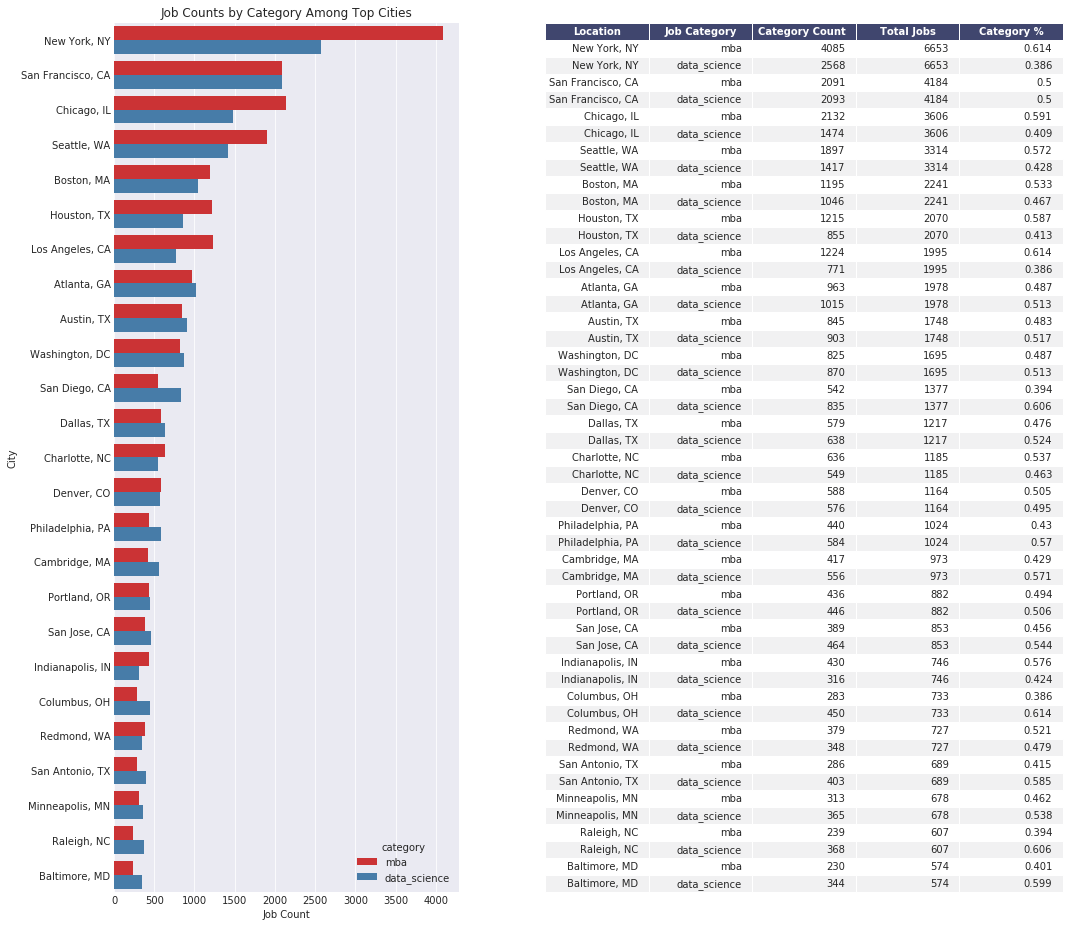

In [658]:
import matplotlib.pyplot as plt
from matplotlib import six
from matplotlib import gridspec
import seaborn as sns

fig = plt.figure(figsize=(17,16))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 6]) 

ax1 = plt.subplot(gs[0])
current_palette_7 = sns.color_palette("Set1", 2)
sns.set_palette(current_palette_7)
sns.barplot(y='Location', x='cat_count', hue="category", data=city_list_ratio, ax=ax1,linewidth=2.5);
sns.despine(left=True, bottom=True)
ax1.set(xlabel='Job Count', ylabel='City');
ax1.set_title('Job Counts by Category Among Top Cities')

ax2 = plt.subplot(gs[1])
ax2.axis('off')
# col_width=20.0
# row_height=2
# font_size=10
header_color='#40466e'
row_colors=['#f1f1f2', 'w']
edge_color='w'
bbox=[0, 0, 1, 1]
header_columns=0

mpl_table = ax2.table(cellText = df1.values, 
                      bbox=bbox, colLabels=['Location','Job Category','Category Count ','Total Jobs','Category %'])

mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

for k, cell in six.iteritems(mpl_table._cells):
    cell.set_edgecolor(edge_color)
    if k[0] == 0 or k[1] < header_columns:
        cell.set_text_props(weight='bold', color='w', wrap=True)
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(row_colors[k[0]%len(row_colors) ])

#### Location Clusters

Now lets take a look at how the cities are clustered.  The clustering algorithm we will use is **K-Means**.  City clusters will be estimated based on the text associated with job postings for a given city.  To accomplish this we will interate through the first 100 cities, pull all text for that city's postings into a corpus and then run kmeans.

In [533]:
top_locations = pd.DataFrame(df_combined.groupby("Location").size().sort_values(ascending=False)[:100])
top_locations.reset_index(inplace=True)
top_locations.columns = ["Location","Count"]
top_locations['text'] = ""

for idx, row in top_locations.iterrows():
    top_locations['text'][idx]= df_combined_clean[df_combined_clean['Location']==\
                                           top_locations['Location'][idx]]['Snippet'].values

top_locations['text'] = top_locations['text'].astype(str)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [534]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_transformer = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,4),
                                          max_df=0.9,
                                          min_df=0.1,
                                          stop_words='english'))])
tfidf_dat = tfidf_transformer.fit_transform(top_locations['text'])

A prerequsite for K-Means is that we need to specify the number of clusters before running the algorithm and one way to decide is via the so-called **"elbow" method**. 

With the elbow method, we track the **distortion** that we discusses earlier over the number of different clusters.  Where we see the 'elbow' in the distortion chart is typically where we should raw the line and use that number of clusters.

In [535]:
from sklearn.cluster import KMeans
distortions = []
for i in range(1,20):
    km = KMeans(n_clusters=i,init='k-means++',n_init=10,
               max_iter=1000,random_state=99)
    km.fit(tfidf_dat)
    distortions.append(km.inertia_)

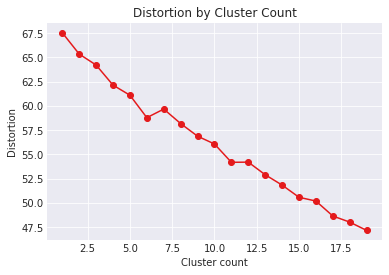

In [536]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(range(1,20),distortions,marker='o')
plt.xlabel('Cluster count')
plt.ylabel('Distortion')
plt.title("Distortion by Cluster Count")
plt.show;

From the above chart we do not really see an elbow form. This signifies that perhaps clustering based on city alone does not create sufficient differences in the data.  This might be because the types of postings are increasingly diversified by geographical area as we reach the scale of the number of postings used in this analysis.

To continue the analysis, let's arbitrarily go ahead and choose 3 clusters to fit our K-means model.

In [537]:
km = KMeans(n_clusters=3,init='k-means++',n_init=10,
           max_iter=1000,random_state=99)
km.fit(tfidf_dat)
top_locations['cluster_num'] = km.labels_

In [538]:
df_cluster_one = top_locations[top_locations['cluster_num']==0]
df_cluster_two = top_locations[top_locations['cluster_num']==1]
df_cluster_three = top_locations[top_locations['cluster_num']==2]
# df_cluster_four = top_locations[top_locations['cluster_num']==3]
# df_cluster_five = top_locations[top_locations['cluster_num']==4]

##### Top Words per Cluster

What distinguishes these clusters from one another when it comes to the text within them?
Iterating through the three clusters, we can look at the top words associated with each.

As we suspected above, the differences between clusters might be more subtle than we would have hoped.
We see that the three clusters share many of the same words like 'degree','experience','field'.

In [539]:
for i in range(3):
    cluster = top_locations[top_locations['cluster_num']==i]
    result = Counter(" ".join(cluster["text"].values.tolist()).split(" "))
    word_counts_cluster = pd.DataFrame.from_dict(result, orient='index').reset_index()
    word_counts_cluster.columns = ['word','count']
    word_counts_cluster.sort_values("count",ascending=False,inplace=True)
    word_counts_cluster.reset_index(inplace=True)
    k = i + 1
    print("Top Words in Cluster %d" % k)
    print(word_counts_cluster.head(10))
    print()

Top Words in Cluster 1
   index         word  count
0  8062   experience   6692 
1  7745   engineering  6605 
2  3549   develop      6440 
3  17930  data         6176 
4  8495   technical    6170 
5  7098   degree       6142 
6  7770   field        5801 
7  15975  business     5596 
8  15920  design       5473 
9  17891  computer     5273 

Top Words in Cluster 2
   index      word  count
0  145    data      7    
1  172    analysis  5    
2  151    develop   4    
3  132    staffing  3    
4  109    business  3    
5  113    team      3    
6  162    models    2    
7  123    capital   2    
8  72     design    2    
9  30     level     2    

Top Words in Cluster 3
   index        word  count
0  6668   degree      5674 
1  11185  field       5168 
2  7599   experience  4858 
3  14909  business    4657 
4  18067  related     4641 
5  3339   develop     4585 
6  7989   technical   3888 
7  12889  analysis    3729 
8  16765  data        3669 
9  14857  design      3656 



In [540]:
cluster_colors = {0:"red",
                 1:"orange",
                 2:"green",
                 3:"blue"}
#                  4:"purple"}
#                  5:"purple"}

cluster_names = {0:"Cluster 1",
                 1:"Cluster 2",
                 2:"Cluster 3"}
# ,
#                  3:"Data/Analyst",
#                  4:"Marketing/Product Management"}
        
#                 5:"?"}

Lets take a look at how are clusters form via MDS.  There are not many evident differences between the clusters when it comes to which cities are contained in each.  This further supports the possibility that clustering by city alone is not effective in uncovering patterns in the data.

In [541]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_dat)

In [542]:
mds = MDS(n_components=2,dissimilarity="precomputed",random_state=99)
coords = mds.fit_transform(dist)
x,y = coords[:,0],coords[:,1]

mds_df = pd.DataFrame(dict(x=x,y=y,
               cluster=top_locations['cluster_num'],
              locations = top_locations['Location']))

clusters = mds_df.groupby('cluster')

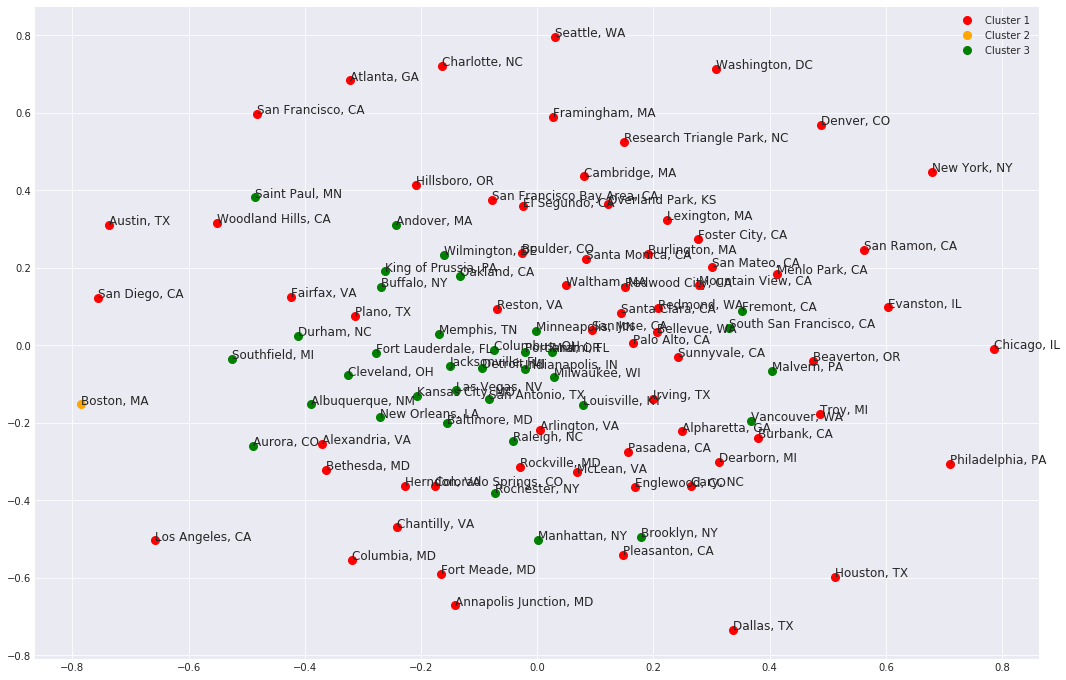

In [543]:
fig, ax = plt.subplots(figsize=(18, 12))

ax.margins(0.05)
for name, group in clusters:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name])
    
ax.legend(numpoints=1)  
for idx, row in mds_df.iterrows():
    ax.text(row['x'],row['y'],
           row['locations'],size=12)
    
plt.show()

#### Testing Heirarchical

WIP

In [544]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import euclidean_distances

dist = euclidean_distances(tfidf_dat)
x = ward(dist)

/usr/local/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [546]:
x.shape

(99, 4)

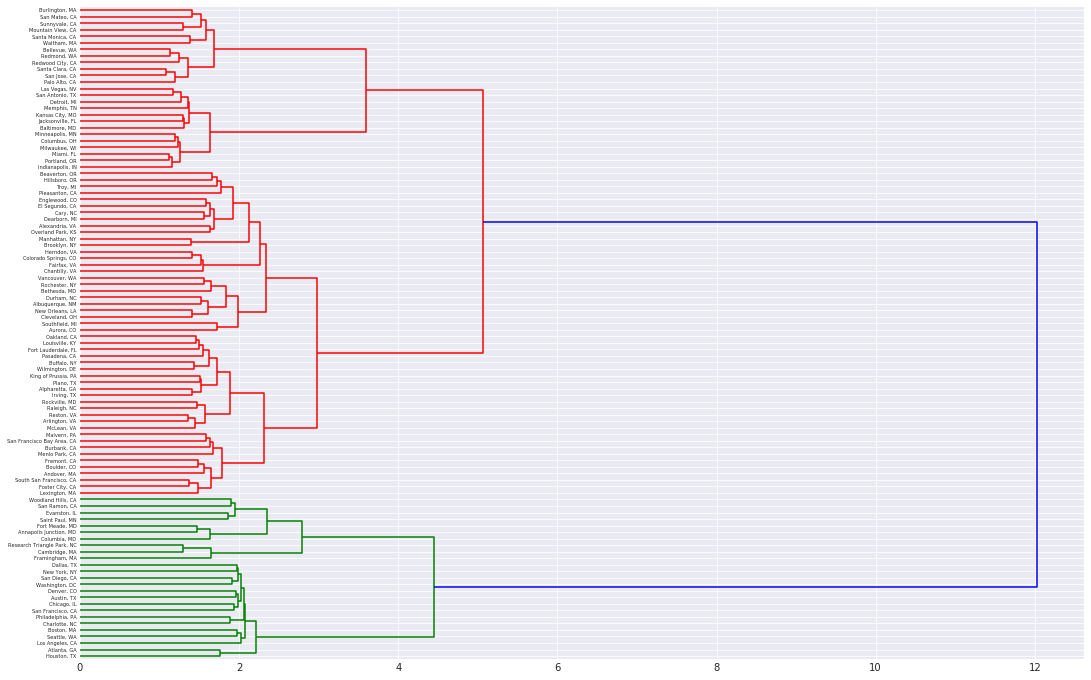

In [561]:
cities = list(top_locations['Location'])
fig, ax1 = plt.subplots(figsize=(18, 12))

ax = dendrogram(x, orientation="right", labels=cities)

### Companies

What are the similarities and differences of the firms posting the jobs? Lets start by taking a look at which firms hire Data Scientsits and where they are located.

#### Top Companies by City

Lets take a look at the top 5 companies hiring in each of the top 10 cities as measured by the number of postings they have.  We group by city and then by company, sorting by record count to display city and company ranks below.

##### Data Science

For Data Science, quite a few universities and hospital systems make the list.

Amongst more technology-centric cities like Seattle and San Francisco, tech firms dominate the list.

In [431]:
# group by city, company and create company ranks based on number of jobs
ds_top_company_by_city = pd.DataFrame(df_data_sci.groupby(['Location','Company']).size().reset_index())
ds_top_company_by_city.columns = ['Location','Company','Count']
ds_top_company_by_city.sort_values(['Location','Count'],ascending=False,inplace=True)
ds_top_company_by_city['company_rank'] = ds_top_company_by_city.groupby('Location')['Count'].rank(method='first',ascending=False).astype(int)
# group by city and create city ranks based on number of jobs
city_ranks = pd.DataFrame(df_data_sci.groupby('Location').size().rank(method='first',ascending=False).astype(int).reset_index())
city_ranks.columns = ['Location','city_rank']
ds_top_company_by_city = pd.merge(ds_top_company_by_city,city_ranks,how="inner",on="Location")
ds_top_company_by_city.sort_values(['city_rank','company_rank'],inplace=True)

In [432]:
ds_top_company_by_city.groupby('Location').head()[:50]

,Location,Company,Count,company_rank,city_rank
6278,"New York, NY",JP Morgan Chase,77,1,1
6279,"New York, NY",PricewaterhouseCoopers LLC,63,2,1
6280,"New York, NY",Averity,56,3,1
6281,"New York, NY",Columbia University,50,4,1
6282,"New York, NY",Mount Sinai Health System,41,5,1
2703,"San Francisco, CA",University of California San Francisco,65,1,2
2704,"San Francisco, CA",Salesforce,57,2,2
2705,"San Francisco, CA",Uber,40,3,2
2706,"San Francisco, CA",BuzzHero,39,4,2
2707,"San Francisco, CA",Twitter,37,5,2


##### MBA

For MBA jobs, financial firms dominate the list, with a fair representation by tech firms as well.  Seattle's market for MBA's is almost totally dominated by Amazon affiliate companies.

In [433]:
# group by city, company and create company ranks based on number of jobs
mba_top_company_by_city = pd.DataFrame(df_mba.groupby(['Location','Company']).size().reset_index())
mba_top_company_by_city.columns = ['Location','Company','Count']
mba_top_company_by_city.sort_values(['Location','Count'],ascending=False,inplace=True)
mba_top_company_by_city['company_rank'] = mba_top_company_by_city.groupby('Location')['Count'].rank(method='first',ascending=False).astype(int)
# group by city and create city ranks based on number of jobs
city_ranks = pd.DataFrame(df_mba.groupby('Location').size().rank(method='first',ascending=False).astype(int).reset_index())
city_ranks.columns = ['Location','city_rank']
mba_top_company_by_city = pd.merge(mba_top_company_by_city,city_ranks,how="inner",on="Location")
mba_top_company_by_city.sort_values(['city_rank','company_rank'],inplace=True)

In [434]:
mba_top_company_by_city.groupby('Location').head()[:50]

,Location,Company,Count,company_rank,city_rank
5553,"New York, NY",JP Morgan Chase,121,1,1
5554,"New York, NY",Michael Page US,71,2,1
5555,"New York, NY",American Express,64,3,1
5556,"New York, NY",BNY Mellon,62,4,1
5557,"New York, NY",Citi,60,5,1
12776,"Chicago, IL",University of Chicago,95,1,2
12777,"Chicago, IL",United Airlines Inc.,78,2,2
12778,"Chicago, IL",JP Morgan Chase,34,3,2
12779,"Chicago, IL",KPMG,32,4,2
12780,"Chicago, IL",BMO Financial Group,30,5,2


#### Top Companies by Category

Who are the top hiring companies for data scientists? For MBA's? It looks like Amazon and Microsoft lead in both categories.  The importance of data science in the financial sector is evident by the presence of several banks near the top of the data science list.

In [435]:
ds_job_comps = pd.DataFrame((df_data_sci
     .groupby('Company')
     .count()
     .sort_values('Location',ascending=False)['Location']
     .reset_index()))
mba_job_comps = pd.DataFrame((df_mba
     .groupby('Company')
     .count()
     .sort_values('Location',ascending=False)['Location']
     .reset_index()))
combined_comps = pd.concat([mba_job_comps, ds_job_comps], axis=1)
combined_comps.columns = ['MBA_Companies','Job_Counts',
                         'DS_Companies','Job_Counts']

In [436]:
combined_comps.head(20)

,MBA_Companies,Job_Counts,DS_Companies,Job_Counts
0,Amazon Corporate LLC,947.0,Amazon Corporate LLC,549
1,Microsoft,517.0,Microsoft,355
2,JP Morgan Chase,370.0,Leidos,300
3,Emerson,330.0,Northrop Grumman,246
4,Wells Fargo,293.0,PricewaterhouseCoopers LLC,241
5,Michael Page US,288.0,FedEx Office,217
6,Bank of America,244.0,Wells Fargo,193
7,Google,231.0,Axius Technologies,190
8,"Anthem, Inc.",218.0,JP Morgan Chase,186
9,"Amazon Web Services, Inc.",195.0,Global Payments,185


#### Top Company Category Ratios

Among our top hirers, it is harder to find those with near even splits between MBA and Data Science positions. A few whose ratios come closest include Microsoft, Wells Fargo and Google.

In [662]:
company_list_ratio = pd.DataFrame(df_combined
                               .groupby(['Company','category'])
                               .size()).reset_index().sort_values(0,ascending=False)
company_list_totals = company_list_ratio.groupby("Company").agg({0:np.sum})
company_list_totals['Company'] = company_list_totals.index
company_list_ratio = company_list_ratio.merge(company_list_totals,how="inner",on="Company")
company_list_ratio.columns = ["Company","category","cat_count","tot_count"]
company_list_ratio['cat_pct'] = company_list_ratio['cat_count']/company_list_ratio['tot_count']
company_list_ratio = company_list_ratio.sort_values(['tot_count','Company','category'],ascending=False)
company_list_ratio = company_list_ratio.head(50)
df1 = pd.DataFrame(company_list_ratio.head(50))
df1['cat_pct'] = round(df1['cat_pct'],3)

In [664]:
# import seaborn as sns
# %matplotlib inline

# current_palette_7 = sns.color_palette("Set1", 2)
# sns.set_palette(current_palette_7)

# fig, ax1 = plt.subplots(figsize=(12, 8))
# sns.barplot(y='Company', x='cat_count', hue="category", data=company_list_ratio, ax=ax1,linewidth=2.5);
# sns.despine(left=True, bottom=True)
# ax1.set(xlabel='Job Count', ylabel='City');
# ax1.set_title('Job Counts by Category Among Top Companies')

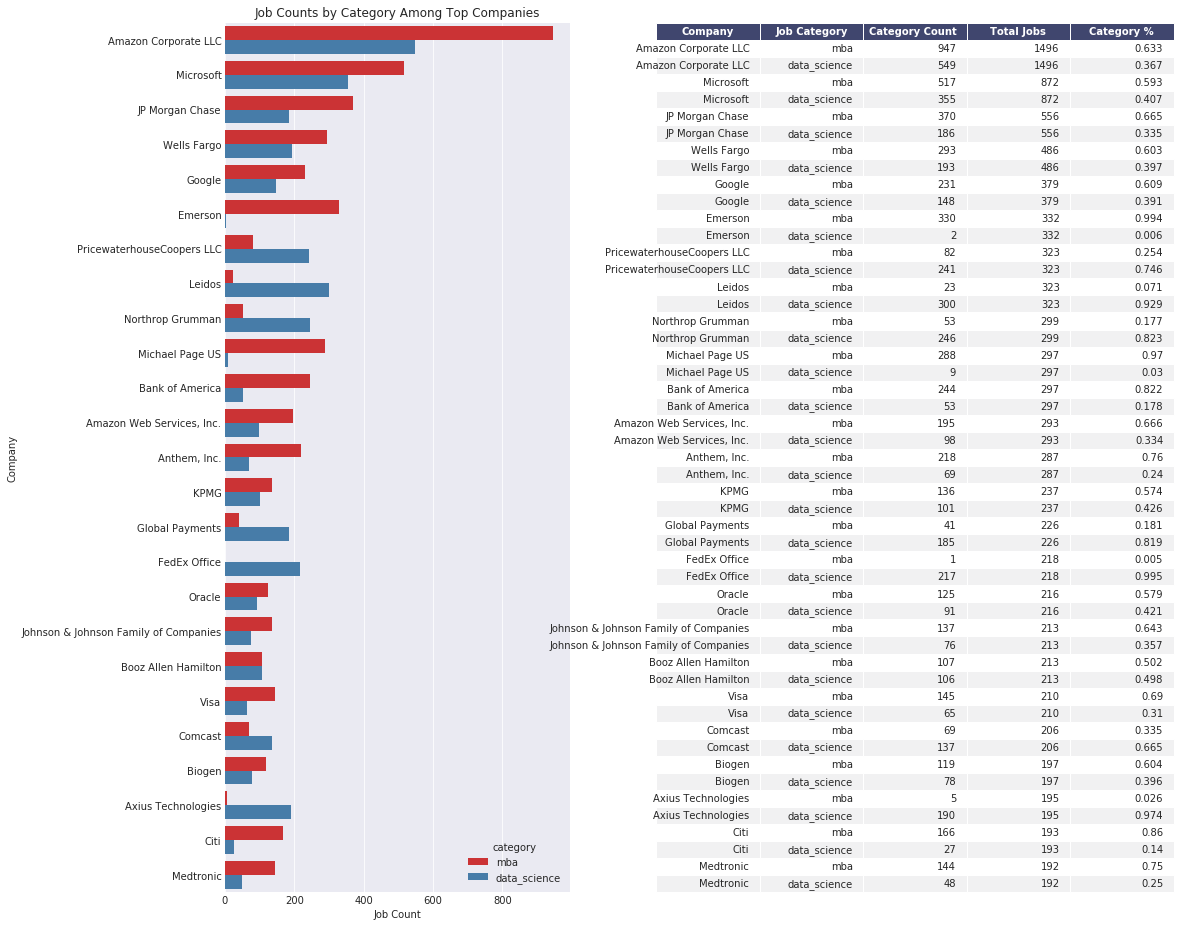

In [666]:
import matplotlib.pyplot as plt
from matplotlib import six
from matplotlib import gridspec
import seaborn as sns

fig = plt.figure(figsize=(17,16))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 6]) 

ax1 = plt.subplot(gs[0])
# current_palette_7 = sns.color_palette("Set1", 2)
# sns.set_palette(current_palette_7)
# sns.barplot(y='Location', x='cat_count', hue="category", data=city_list_ratio, ax=ax1,linewidth=2.5);
# sns.despine(left=True, bottom=True)
# ax1.set(xlabel='Job Count', ylabel='City');
# ax1.set_title('Job Counts by Category Among Top Cities')

current_palette_7 = sns.color_palette("Set1", 2)
sns.set_palette(current_palette_7)
sns.barplot(y='Company', x='cat_count', hue="category", data=company_list_ratio, ax=ax1,linewidth=2.5);
sns.despine(left=True, bottom=True)
ax1.set(xlabel='Job Count', ylabel='Company');
ax1.set_title('Job Counts by Category Among Top Companies')

ax2 = plt.subplot(gs[1])
ax2.axis('off')
# col_width=20.0
# row_height=2
# font_size=10
header_color='#40466e'
row_colors=['#f1f1f2', 'w']
edge_color='w'
bbox=[0, 0, 1, 1]
header_columns=0

mpl_table = ax2.table(cellText = df1.values, 
                      bbox=bbox, colLabels=['Company','Job Category','Category Count ','Total Jobs','Category %'])

mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

for k, cell in six.iteritems(mpl_table._cells):
    cell.set_edgecolor(edge_color)
    if k[0] == 0 or k[1] < header_columns:
        cell.set_text_props(weight='bold', color='w', wrap=True)
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(row_colors[k[0]%len(row_colors) ])

#### Company Clusters

Once again, as we did with the job locations above, let's aggregate the job text data by company and form clusters via K-Means. We will take the top 100 companies as measured by the number of jobs they have posted.

In [440]:
top_companies = pd.DataFrame(df_combined.groupby("Company").size().sort_values(ascending=False)[:100])
top_companies.reset_index(inplace=True)
top_companies.columns = ["Company","Count"]
top_companies['text'] = ""

for idx, row in top_companies.iterrows():
    top_companies['text'][idx]= df_combined_clean[df_combined_clean['Company']==\
                                           top_companies['Company'][idx]]['Snippet'].values

top_companies['text'] = top_companies['text'].astype(str)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [441]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_transformer = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,4),
                                          max_df=0.9,
                                          min_df=0.1,
                                          stop_words='english'))])
tfidf_dat = tfidf_transformer.fit_transform(top_companies['text'])

In [442]:
from sklearn.cluster import KMeans
distortions = []
for i in range(1,20):
    km = KMeans(n_clusters=i,init='k-means++',n_init=10,
               max_iter=1000,random_state=99)
    km.fit(tfidf_dat)
    distortions.append(km.inertia_)

Again, we do not see an obvious elbow in the below plot.  This time, however, lets use five clusters.

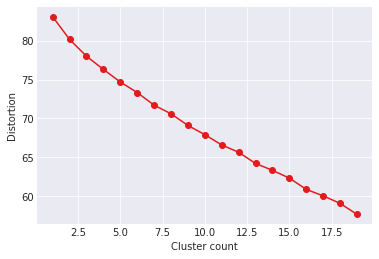

In [443]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(range(1,20),distortions,marker='o')
plt.xlabel('Cluster count')
plt.ylabel('Distortion')
plt.show;

In [454]:
km = KMeans(n_clusters=3,init='k-means++',n_init=10,
           max_iter=1000,random_state=101)
km.fit(tfidf_dat)
top_companies['cluster_num'] = km.labels_

In [455]:
df_cluster_one = top_companies[top_companies['cluster_num']==0]
df_cluster_two = top_companies[top_companies['cluster_num']==1]
df_cluster_three = top_companies[top_companies['cluster_num']==2]
# df_cluster_four = top_companies[top_companies['cluster_num']==3]
# df_cluster_five = top_companies[top_companies['cluster_num']==4]
# df_cluster_six = df_combined_clean[df_combined_clean['cluster_num']==5]

In [456]:
for i in range(3):
    cluster = top_companies[top_companies['cluster_num']==i]
    result = Counter(" ".join(cluster["text"].values.tolist()).split(" "))
    word_counts_cluster = pd.DataFrame.from_dict(result, orient='index').reset_index()
    word_counts_cluster.columns = ['word','count']
    word_counts_cluster.sort_values("count",ascending=False,inplace=True)
    word_counts_cluster.reset_index(inplace=True)
    k = i + 1
    print("Top Words in Cluster %d" % k)
    print(word_counts_cluster.head(10))
    print()

Top Words in Cluster 1
   index         word  count
0  4372   engineering  3927 
1  4791   technical    3510 
2  4549   experience   3169 
3  3985   degree       3013 
4  10223  data         2992 
5  4385   field        2882 
6  10200  computer     2825 
7  6434   business     2725 
8  9086   design       2640 
9  2019   develop      2502 

Top Words in Cluster 2
   index        word  count
0  6881   business    3575 
1  3934   develop     3395 
2  9630   analysis    2489 
3  8525   field       2382 
4  8846   experience  2301 
5  7760   degree      2206 
6  6820   design      2093 
7  3666   management  2025 
8  9348   technical   1902 
9  9031   data        1837 

Top Words in Cluster 3
   index        word  count
0  2265   degree      564  
1  4819   related     564  
2  2969   field       560  
3  98     clinical    438  
4  3712   state       394  
5  3268   experience  377  
6  3651   develop     370  
7  2238   research    361  
8  3536   nursing     292  
9  3435   data        

We see a bit more differentiation among the clusters than we did when we clustered on city. Lets assign some broad descriptions for each cluster.
* Cluster 1 - Enginnering & Technical Terms
* Cluster 2 - Buiness & Analysis Terms
* Cluster 3 - Research & Development Terms

In [457]:
cluster_colors = {0:"red",
#                  1:"orange",
#                  2:"green",
                 1:"blue",
                 2:"yellow"}
#                  5:"purple"}

cluster_names = {0:"Enginnering & Technical",
                 1:"Buiness & Analysis",
                 2:"Research & Development"}
# ,
#                  3:"Data/Analyst",
#                  4:"Marketing/Product Management"}
        
#                 5:"?"}

In [458]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_dat)

In [459]:
mds = MDS(n_components=2,dissimilarity="precomputed",random_state=99)
coords = mds.fit_transform(dist)
x,y = coords[:,0],coords[:,1]

mds_df = pd.DataFrame(dict(x=x,y=y,
               cluster=top_companies['cluster_num'],
              companies = top_companies['Company']))

clusters = mds_df.groupby('cluster')

Looking at the below plot, we can see how effective our K-Means assigned companies to the three overall clusters we created.
* The Red Cluster, representing postings with engineering & technical descriptions is mostly made up of Tech companies
* The Blue Cluster, with postings mainly related to business & analysis is mostly made up of Financial Companies with some pharmaceautical companies sprinkled in.
* The Yellow Cluster, made of up mostly research-related job postings, is dominated by universities.

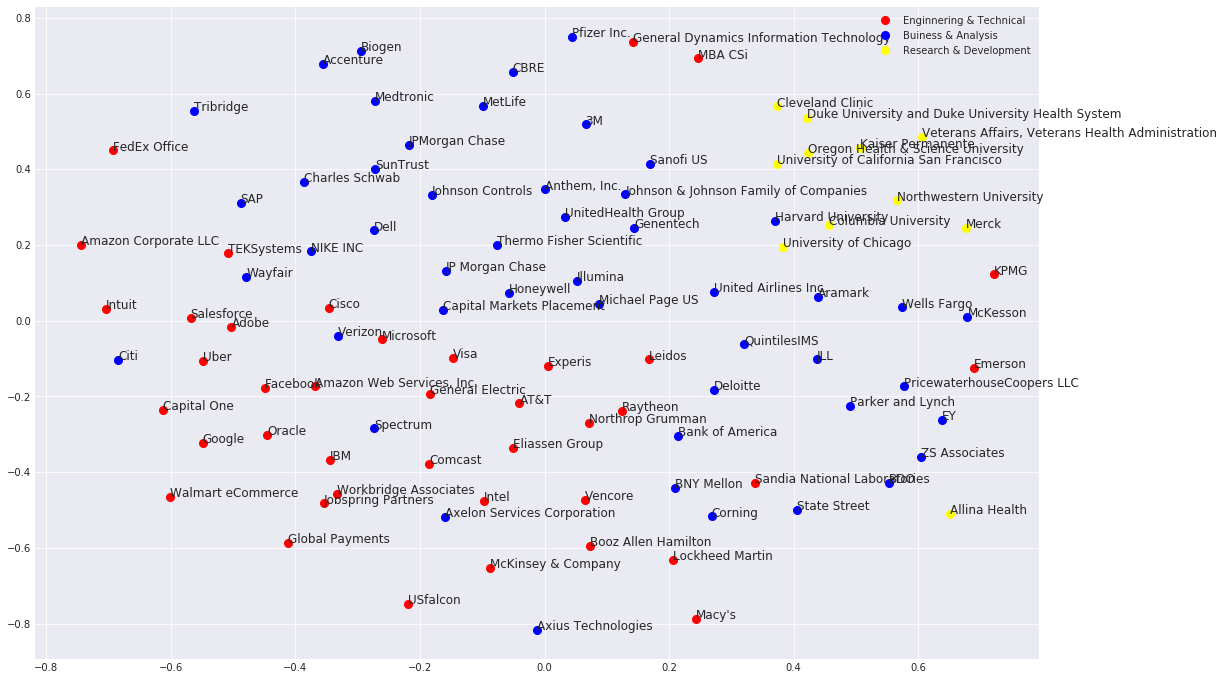

In [460]:
fig, ax = plt.subplots(figsize=(18, 12))

ax.margins(0.05)
for name, group in clusters:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name])
    
ax.legend(numpoints=1)  
for idx, row in mds_df.iterrows():
    ax.text(row['x'],row['y'],
           row['companies'],size=12)
    
plt.show()

### Job Titles

Looking at the top job titles by job category, there seems to be less diversity for data science titles than mba titles.

In [461]:
ds_job_titles = pd.DataFrame((df_data_sci
     .groupby('Job_Title')
     .count()
     .sort_values('Company',ascending=False)['Company']
     .head(20).reset_index()))
mba_job_titles = pd.DataFrame((df_mba
     .groupby('Job_Title')
     .count()
     .sort_values('Company',ascending=False)['Company']
     .head(20).reset_index()))
combined_titles = pd.concat([mba_job_titles,ds_job_titles], axis=1)
combined_titles.columns = ['MBA_Titles','Job_Counts',
                         'DS_Titles','Job_Counts']

In [462]:
combined_titles

,MBA_Titles,Job_Counts,DS_Titles,Job_Counts
0,Senior Financial Analyst,325,Data Scientist,631
1,Financial Analyst,285,Software Engineer,333
2,Product Manager,278,Senior Software Engineer,243
3,Controller,231,Retail Customer Service Associate,210
4,Project Manager,179,Data Analyst,173
5,Senior Accountant,162,Data Engineer,168
6,Finance Manager,150,Senior Data Scientist,162
7,Product Marketing Manager,147,Software Developer,95
8,Program Manager,127,Business Analyst,87
9,Senior Product Manager,125,Software Development Engineer,72


#### Top Titles by City

##### Data Science

In [463]:
# group by city, company and create company ranks based on number of jobs
ds_top_title_by_city = pd.DataFrame(df_data_sci.groupby(['Location','Job_Title']).size().reset_index())
ds_top_title_by_city.columns = ['Location','Title','Count']
ds_top_title_by_city.sort_values(['Location','Count'],ascending=False,inplace=True)
ds_top_title_by_city['title_rank'] = ds_top_title_by_city.groupby('Location')['Count'].rank(method='first',ascending=False).astype(int)
# group by city and create city ranks based on number of jobs
city_ranks = pd.DataFrame(df_data_sci.groupby('Location').size().rank(method='first',ascending=False).astype(int).reset_index())
city_ranks.columns = ['Location','city_rank']
ds_top_title_by_city = pd.merge(ds_top_title_by_city,city_ranks,how="inner",on="Location")
ds_top_title_by_city.sort_values(['city_rank','title_rank'],inplace=True)

In [23]:
ds_top_title_by_city.groupby('Location').head()[:50]

,Location,Title,Count,title_rank,city_rank
4111,"New York, NY",Data Scientist,97,1,1
4112,"New York, NY",Senior Data Scientist,30,2,1
4113,"New York, NY",Data Engineer,15,3,1
4114,"New York, NY",Data Analyst,12,4,1
4115,"New York, NY",Product Manager,12,5,1
1677,"San Francisco, CA",Data Scientist,65,1,2
1678,"San Francisco, CA",Data Engineer,22,2,2
1679,"San Francisco, CA",Data Analyst,21,3,2
1680,"San Francisco, CA",Senior Data Scientist,18,4,2
1681,"San Francisco, CA",Backend Engineer (MS1),15,5,2


##### MBA

In [464]:
# group by city, company and create company ranks based on number of jobs
mba_top_title_by_city = pd.DataFrame(df_mba.groupby(['Location','Job_Title']).size().reset_index())
mba_top_title_by_city.columns = ['Location','Title','Count']
mba_top_title_by_city.sort_values(['Location','Count'],ascending=False,inplace=True)
mba_top_title_by_city['title_rank'] = mba_top_title_by_city.groupby('Location')['Count'].rank(method='first',ascending=False).astype(int)
# group by city and create city ranks based on number of jobs
city_ranks = pd.DataFrame(df_mba.groupby('Location').size().rank(method='first',ascending=False).astype(int).reset_index())
city_ranks.columns = ['Location','city_rank']
mba_top_title_by_city = pd.merge(mba_top_title_by_city,city_ranks,how="inner",on="Location")
mba_top_title_by_city.sort_values(['city_rank','title_rank'],inplace=True)

In [465]:
mba_top_title_by_city.groupby('Location').head()[:50]

,Location,Title,Count,title_rank,city_rank
11083,"New York, NY",Senior Financial Analyst,26,1,1
11084,"New York, NY",Project Manager,19,2,1
11085,"New York, NY",Product Manager,17,3,1
11086,"New York, NY",Financial Analyst,15,4,1
11087,"New York, NY",Controller,13,5,1
24763,"Chicago, IL",Senior Financial Analyst,16,1,2
24764,"Chicago, IL",Senior Accountant,11,2,2
24765,"Chicago, IL",Engagement Manager,10,3,2
24766,"Chicago, IL",Finance Manager,9,4,2
24767,"Chicago, IL",Account Manager,8,5,2


#### Top Titles by Company

##### Data Science

In [466]:
# group by city, company and create company ranks based on number of jobs
ds_top_title_by_company = pd.DataFrame(df_data_sci.groupby(['Company','Job_Title']).size().reset_index())
ds_top_title_by_company.columns = ['Company','Title','Count']
ds_top_title_by_company.sort_values(['Company','Count'],ascending=False,inplace=True)
ds_top_title_by_company['title_rank'] = ds_top_title_by_company.groupby('Company')['Count'].rank(method='first',ascending=False).astype(int)
# group by city and create city ranks based on number of jobs
city_ranks = pd.DataFrame(df_data_sci.groupby('Company').size().rank(method='first',ascending=False).astype(int).reset_index())
city_ranks.columns = ['Company','company_rank']
ds_top_title_by_company = pd.merge(ds_top_title_by_company,city_ranks,how="inner",on="Company")
ds_top_title_by_company.sort_values(['company_rank','title_rank'],inplace=True)

In [467]:
ds_top_title_by_company.groupby('Company').head()[:50]

,Company,Title,Count,title_rank,company_rank
32693,Amazon Corporate LLC,Software Development Engineer,44,1,1
32694,Amazon Corporate LLC,Software Development Manager,12,2,1
32695,Amazon Corporate LLC,Business Intelligence Engineer,10,3,1
32696,Amazon Corporate LLC,Data Scientist,8,4,1
32697,Amazon Corporate LLC,Senior Software Development Engineer,7,5,1
15353,Microsoft,Senior Software Engineer,29,1,2
15354,Microsoft,Software Engineer II,18,2,2
15355,Microsoft,Senior Program Manager,16,3,2
15356,Microsoft,Principal Software Engineer,12,4,2
15357,Microsoft,Software Engineer,12,5,2


##### MBA

In [28]:
# group by city, company and create company ranks based on number of jobs
mba_top_title_by_company = pd.DataFrame(df_mba.groupby(['Company','Job_Title']).size().reset_index())
mba_top_title_by_company.columns = ['Company','Title','Count']
mba_top_title_by_company.sort_values(['Company','Count'],ascending=False,inplace=True)
mba_top_title_by_company['title_rank'] = mba_top_title_by_company.groupby('Company')['Count'].rank(method='first',ascending=False).astype(int)
# group by city and create city ranks based on number of jobs
city_ranks = pd.DataFrame(df_mba.groupby('Company').size().rank(method='first',ascending=False).astype(int).reset_index())
city_ranks.columns = ['Company','company_rank']
mba_top_title_by_company = pd.merge(mba_top_title_by_company,city_ranks,how="inner",on="Company")
mba_top_title_by_company.sort_values(['company_rank','title_rank'],inplace=True)

In [29]:
mba_top_title_by_company.groupby('Company').head()[:50]

,Company,Title,Count,title_rank,company_rank
22766,Amazon Corporate LLC,Sr. Product Manager,15,1,1
22767,Amazon Corporate LLC,Senior Financial Analyst,11,2,1
22768,Amazon Corporate LLC,Finance Manager,9,3,1
22769,Amazon Corporate LLC,Senior Product Manager,8,4,1
22770,Amazon Corporate LLC,Sr. Program Manager,7,5,1
9627,Microsoft,Principal Program Manager,11,1,2
9628,Microsoft,Ent Channel Mgr,9,2,2
9629,Microsoft,Senior Product Marketing Manager,7,3,2
9630,Microsoft,Business Program Manager,6,4,2
9631,Microsoft,Senior Program Manager,6,5,2


#### Job-Titles Clusters

In [104]:
top_titles = pd.DataFrame(df_combined.groupby("Job_Title").size().sort_values(ascending=False)[:100])
top_titles.reset_index(inplace=True)
top_titles.columns = ["Job_Title","Count"]
top_titles['text'] = ""

for idx, row in top_titles.iterrows():
    top_titles['text'][idx]= df_combined_clean[df_combined_clean['Job_Title']==\
                                           top_titles['Job_Title'][idx]]['Snippet'].values

top_titles['text'] = top_titles['text'].astype(str)

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_transformer = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,4),
                                          max_df=0.9,
                                          min_df=0.1,
                                          stop_words='english'))])
tfidf_dat = tfidf_transformer.fit_transform(top_titles['text'])

In [247]:
from sklearn.cluster import KMeans
distortions = []
for i in range(1,20):
    km = KMeans(n_clusters=i,init='k-means++',n_init=10,
               max_iter=1000,random_state=99)
    km.fit(tfidf_dat)
    distortions.append(km.inertia_)

**Distortion**
Below we plot the distortions for each number of clusters.  The common method for determining the number of clusters is to select the number where the 'elbow' forms.  In the below plot we can see an elbow forming around the 4-5 mark.  We will go with 5 clusters.

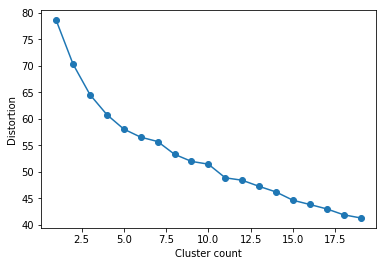

In [297]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(range(1,20),distortions,marker='o')
plt.xlabel('Cluster count')
plt.ylabel('Distortion')
plt.show;

In [259]:
km = KMeans(n_clusters=5,init='k-means++',n_init=10,
           max_iter=1000,random_state=99)
km.fit(tfidf_dat)
top_titles['cluster_num'] = km.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=99, tol=0.0001, verbose=0)

In [261]:
df_cluster_one = top_titles[top_titles['cluster_num']==0]
df_cluster_two = top_titles[top_titles['cluster_num']==1]
df_cluster_three = top_titles[top_titles['cluster_num']==2]
df_cluster_four = top_titles[top_titles['cluster_num']==3]
df_cluster_five = top_titles[top_titles['cluster_num']==4]
# df_cluster_six = df_combined_clean[df_combined_clean['cluster_num']==5]

In [262]:
for i in range(5):
    cluster = top_titles[top_titles['cluster_num']==i]
    result = Counter(" ".join(cluster["text"].values.tolist()).split(" "))
    word_counts_cluster = pd.DataFrame.from_dict(result, orient='index').reset_index()
    word_counts_cluster.columns = ['word','count']
    word_counts_cluster.sort_values("count",ascending=False,inplace=True)
    word_counts_cluster.reset_index(inplace=True)
    k = i + 1
    print("Top Words in Cluster %d" % k)
    print(word_counts_cluster.head(10))
    print()

Top Words in Cluster 1
   index        word  count
0  1282   financial   2003 
1  833    analysis    1579 
2  4577   accounting  1295 
3  5812   business    907  
4  437    finance     879  
5  1884   develop     723  
6  4883   reporting   720  
7  4169   degree      644  
8  4123   management  619  
9  4059   experience  571  

Top Words in Cluster 2
   index        word  count
0  2695   management  913  
1  2591   project     727  
2  4650   business    612  
3  1633   quality     587  
4  2559   driven      479  
5  56     regular     467  
6  230    attendance  464  
7  1175   technical   460  
8  3160   develop     437  
9  2051   experience  435  

Top Words in Cluster 3
   index         word  count
0  6642   data         2034 
1  7041   computer     1882 
2  3049   design       1752 
3  7339   engineering  1589 
4  5175   experience   1408 
5  4829   software     1383 
6  945    technical    1351 
7  5322   degree       1295 
8  5539   related      1103 
9  2086   field        

In [281]:
cluster_colors = {0:"red",
                 1:"orange",
                 2:"green",
                 3:"blue",
                 4:"purple"}
#                  5:"purple"}

cluster_names = {0:"Finance/Accounting",
                 1:"Product Management",
                 2:"Data/Engineering",
                 3:"Data/Analyst",
                 4:"Marketing/Product Management"}
        
#                 5:"?"}

In [282]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_dat)

In [283]:
mds = MDS(n_components=2,dissimilarity="precomputed",random_state=99)
coords = mds.fit_transform(dist)
x,y = coords[:,0],coords[:,1]

mds_df = pd.DataFrame(dict(x=x,y=y,
               cluster=top_titles['cluster_num'],
              job_titles = top_titles['Job_Title']))

clusters = mds_df.groupby('cluster')

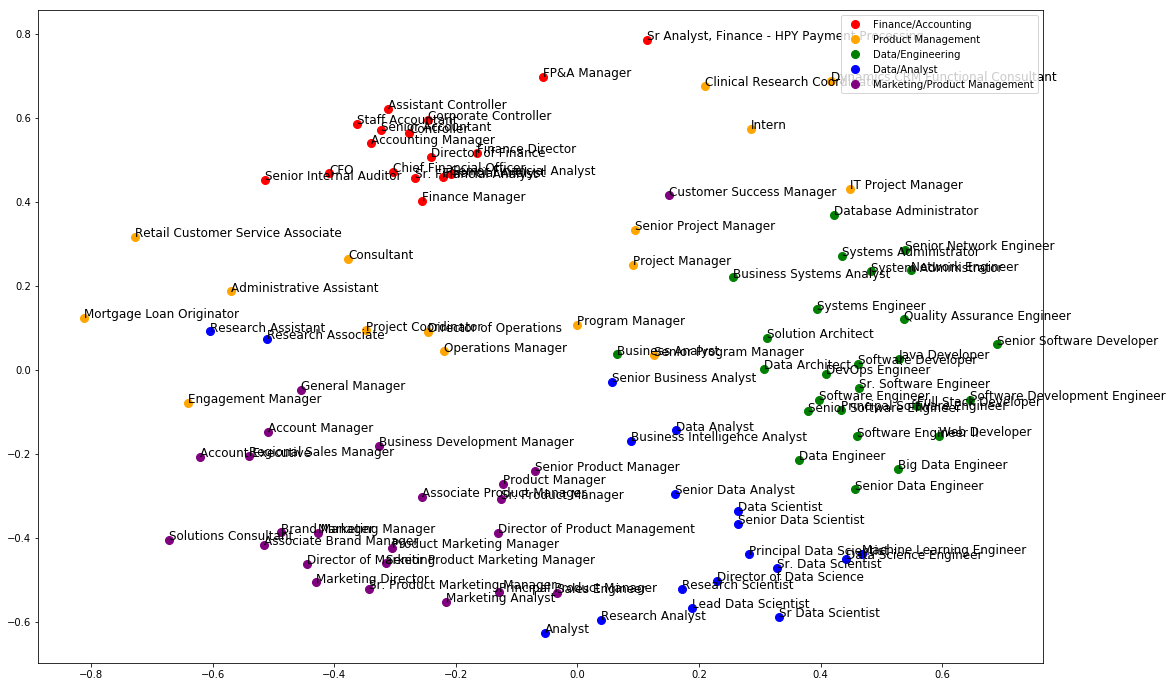

In [296]:
fig, ax = plt.subplots(figsize=(18, 12))

ax.margins(0.05)
for name, group in clusters:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name])
    
ax.legend(numpoints=1)  
for idx, row in mds_df.iterrows():
    ax.text(row['x'],row['y'],
           row['job_titles'],size=12)
    
plt.show()

# Pre-modeling steps

Soon, wwe will begin the modeling process to classify MBA jobs from Data Science jobs.

1. Train individual models, fitted and tuned on the training set
    * Explore individual classification algorithms and explore hyperparameter options.
2. Combine individual models into an ensemble model, fitted and re-tuned on the training set
    * Explore ensemble classification algorithms and explore hyperparameter options.
3. Evaluate final model performance on test set.

### Split into Training, Validation & Test sets

Before we can train our classification models, several steps need to be taken. The first of which is splitting our dataset into training & test sets.  This is needed in order to determine that our model is not overfitting and classification performance can generalize to new data.

Lets combine our two datasets. We will also make 'MBA' the positive class.

In [468]:
# split into training & test sets
df_combined = df_mba_clean.append(df_data_sci_clean)
df_combined.drop_duplicates(subset='Job_Key',keep='last')
df_combined.reset_index(inplace=True)
df_combined['category'] = np.where(df_combined['category']=="mba",1,0)

In [477]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_combined['Snippet'],df_combined['category'],test_size=0.2,train_size=0.8,random_state=1)

# X, X_test, y, y_test = train_test_split(df_combined['Snippet'],df_combined['category'],test_size=0.2,train_size=0.8,random_state=1)
# X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size = 0.25,train_size =0.75,random_state=1)

In [17]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df_combined['Snippet'],
#                     df_combined['category'],
#                     test_size=0.2,random_state=1)

In [482]:
#for later anlaysis (patterns)
X_train_locations = df_combined.loc[X_train.index,"Location"]
Y_train_locations = df_combined.loc[y_train.index,"Location"]
X_train_companies = df_combined.loc[X_train.index,"Company"]
Y_train_companies = df_combined.loc[y_train.index,"Company"]
X_train_titles = df_combined.loc[X_train.index,"Job_Title"]
Y_train_titles = df_combined.loc[y_train.index,"Job_Title"]
X_train_category = df_combined.loc[X_train.index,"category"]
Y_train_category = df_combined.loc[y_train.index,"category"]

# Model Techniques & Evaluation Metrics

We will also be following a somewhat uniform series of steps for executing the modeling phase, these techniques are used in order to maximize the performance of our specific models.  While the various tuning parameters might vary from one model to the next, the below practices are widely applicable to most of the models we will train in the following sections and classification machine learning problems in general.

### K-fold Cross-Validation

**K-Fold Cross Validation** is a model performance estimation technique which is popular in machine learning.

With K-Fold Cross Validation, the training dataset is randomly split into k folds without replacement.  K-1 folds are used for training the model while the kth fold is used for model testing.  This process is then repeated k times. 

K-fold cross validation is typically used for model tuning, or finding the optimal hyperparameter values that yield good model performance.  Once this process is completed, we can then use those optimal hyperparameter values to train our model on the test set.

You can read more about k-fold cross validation [here](http://scikit-learn.org/stable/modules/cross_validation.html)

### Grid Search

**Grid Search** is a useful, brute force, iterative technique for optimizing hyperparameters of machine learning estimators.  Grid search iterates though all specified combinations of hyperparameters for a given estimator or alogorithm, trains subsequent models on each and records the model's performance as given by a specified score, such as **Area Under the Curve (AUC)** for classification problems or **Mean Squared Error (MSE)** for prediction problems. In this analysis, the metric we use to inform of us of our hyperparameters will be AUC.

You can read more about grid search [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

### Performance Metrics

To assess the performance of our models, we will use a variety of performance metrics.  We will go into brief detail below here:

#### Confusion Matrices

A **Confusion Matrix** is a ....

Rows in the confusion matrix represent 'actual' classes, while columns represent 'predicted' classes.  From a confusion matrix, we can derive the following performance metrics, which will inform us as to the specific strengths and shortcomings of our models.

A sample confusion matrix looks like this:


We will define a function to create confusion matrices for our models as follows:

In [ ]:
def confusion_matrix(y_train,y_pred):
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    confmat = confusion_matrix(y_true=y_train, y_pred=y_pred)
    fix, ax = plt.subplots(figsize=(6,8))
    ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j,y=i,s=confmat[i,j],
                   va='center',ha='center',size=20)
    plt.xlabel('Predicted MBA')
    plt.ylabel('Actual MBA')
    plt.show()

#### Error and Accuracy

The prediction or classification error and accuracy give an overall picture of how many cases are misclassified by a given model.
* **Error** is the sum of all false predictions divided by the sum of total predictions.  As defined below:

\begin{equation*}
Error = \frac{FP+FN}{FP+FN+TP+TN}
\end{equation*}

* **Accuracy** is the sum of all true predictions divided by the sum of total predictions. As defined below:

\begin{equation*}
Accuracy = \frac{TP+TN}{FP+FN+TP+TN}
\end{equation*}

#### True Positive Rate (TPR) & False Positive Rate (FPR)

**True Positive Rate (TPR)** provides the number of positive observations that were correctly identified out of the total number of positives.

\begin{equation*}
TPR = \frac{TP}{P} + \frac{TP}{FN+TP}
\end{equation*}


**False Positive Rate (FPR)** is the ratio of negative samples that are incorrectly classified as positive out of the total number of negatives.

\begin{equation*}
FPR = \frac{FP}{N} + \frac{FP}{FP+TN}
\end{equation*}

#### Precision and Recall

**Precision** is the accuracy of the positive predictions.

\begin{equation*}
Precision = \frac{TP}{TP+FP}
\end{equation*}

**Recall**, also called **Sensitivity** or the **True Positive Rate**, is the ratio of positive instances that are correctly detected by the classifier.

\begin{equation*}
Recall = TPR = \frac{TP}{FN+TP}
\end{equation*}

As a rule, a **Precision/Recall Tradeoff** exists, whereby increasing precision reduces recall and vice versa. This tradeoff can be visualized as a curve.  We will define a function to generate such a plot below for later use:

In [563]:

# y_scores = cross_val_predict(lr_clf,X_train,y_train,method='decision_function',n_jobs=1)
# y_train_bin = y_train
# precisions,recalls,thresholds = precision_recall_curve(y_train_bin,y_scores)

def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import precision_recall_curve
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc='upper left')
    plt.ylim([0,1])
    plt.show()

# plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
# plt.show()

### F1 Score

**F1 Score** is a combination of precision and recall and favors classes with similar precision and recall measures.  

\begin{equation*}
F1 = 2 * \frac{Precision * Recall}{Precision + Recall}
\end{equation*}

### ROC Curve

The **Receiver Operating Characeristic (ROC) curve** is a useful tool for binary classification evaluation and plots the TPR against the FPR or Sensitivity (Recall) versus 1-Specificity.

The ideal ROC Curve has a TPR of 1 and a FPR of 0 or an **Area Under the Curve (AUC)** of 1. Therefore, the AUC characterizes the performance of the model.  A sample ROC Curve looks like this.

WIP

Below we define another function to generate ROC Curves.

In [564]:
# y_scores = cross_val_predict(lr_clf,X_train,y_train,cv=5)
# y_scores = cross_val_predict(lr_clf,X_train,y_train,cv=5,method='decision_function')

# fpr,tpr,thresholds = roc_curve(y_train_bin,y_scores,pos_label=1)

def plot_roc_curve(fpr,tpr,label=None):
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    from sklearn.model_selection import cross_val_predict
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
# plot_roc_curve(fpr,tpr)
# plt.show()

# Training Classifiers

We are ready to begin training and tuning our classification models.  As a reminder, our goal is to correctly classify as many job postings under their actual category (Data Science vs MBA).

We will train and tune the following types of classifiers:
 * Logistic Regression Classifier
 * K Nearest Neighbors Classifier
 * Naive Bayes Classifier
 * Support Vector Machine Classifier
 * Stochastic Gradient Descent Classifier
 * Random Forest Classifier

## Logistic Regression

**Logistic Regression** is a popular, easily implentable linear model classification technique that works with linearly separable data.  Logistic Regression is a probabalistic model that uses a concept called an **Odds Ratio**.  This ratio is the odds in favor of an instance belong to a particular class.  Logistic regression takes the logarithm of the odds ratio to create the so-called **Logit Function** and then takes the inverse of the logit function to produce the **Logistic Function**.  This function produces an output between 0 and 1 which can be interpreted as the probability of a particular observation or sample belonging to the predicted class.  The probability threshold for determining which class is typically 50%, but this can be adjusted depending on the requirements of the problem.

**Regularization**

Regularization is the process of adding a penalty term to the cost function in order to yield smaller coefficient weights, in this way regularization introduces bias to the model.  When employing regularization, the goal is to find the combination of coefficient weights that optimize the cost function of our model while simeltaneously allowing the model to generalize well on new data (bias-variance tradeoff).  More generally, regularization is a tool we use to strike a balance between overfitting (high variance) and underfitting (high vias). In additional, regularization can also help combat multicolinearity among model features and filter out noise from data. With logistic regression, the cost function we are trying to **maximize** through regularization is called the **Log-Likelihood**.

**Hyperparameters explored:**
    * Regularization penalty types:
        * L1 - Yields sparse feature vectors where most feature weights become zero.
        * L2 - Penalizes large individual coefficient weights, shrinking them towards zero.
    * Inverse of Regularization Strength (C):
        * Decreased values of the inverse regularization parameter yields increased regularization strength.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [26]:
lr_clf = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(class_weight="balanced",
                                           n_jobs=-1,
                                           random_state=1,
                                           max_iter=1000,
                                          C=1,
                                          penalty='l2'))
])                   

# parameters = {'clf__penalty':['l1','l2'],
#               'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# lr_clf = GridSearchCV(lr_clf, param_grid=parameters, scoring='roc_auc',n_jobs=-1,cv=10,verbose=True)

# lr_clf.best_params_
# {'clf__C': 1, 'clf__penalty': 'l2'}

lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_train)

In [27]:
print('Train Accuracy: %.3f' % lr_clf.score(X_train, y_train))

Train Accuracy: 0.900


In [28]:
np.mean(y_train==y_pred)

0.8998243653201341

#### Performance Metrics

In [29]:
from sklearn import metrics
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

          0       0.86      0.89      0.88     12570
          1       0.93      0.90      0.92     18745

avg / total       0.90      0.90      0.90     31315



#### Confusion Matrix

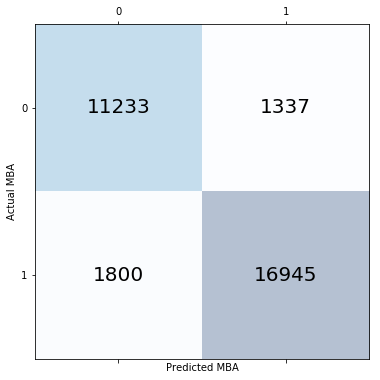

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_train, y_pred=y_pred)
fix, ax = plt.subplots(figsize=(6,8))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],
               va='center',ha='center',size=20)
plt.xlabel('Predicted MBA')
plt.ylabel('Actual MBA')
plt.show()

#### Precision/Recall Curve

In [31]:
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(lr_clf,X_train,y_train,method='decision_function',n_jobs=1)
from sklearn.metrics import precision_recall_curve
y_train_bin = y_train
precisions,recalls,thresholds = precision_recall_curve(y_train_bin,y_scores)

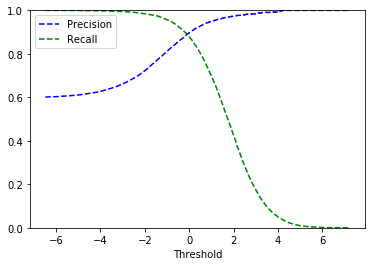

In [32]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

#### ROC Curve

In [33]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_predict
# y_scores = cross_val_predict(lr_clf,X_train,y_train,cv=5)
# y_scores = cross_val_predict(lr_clf,X_train,y_train,cv=5,method='decision_function')

In [34]:
# y_train_bin = np.where(y_train=="mba",1,0)
# y_scores_bin = np.where(y_scores=="mba",1,0)
fpr,tpr,thresholds = roc_curve(y_train_bin,y_scores,pos_label=1)

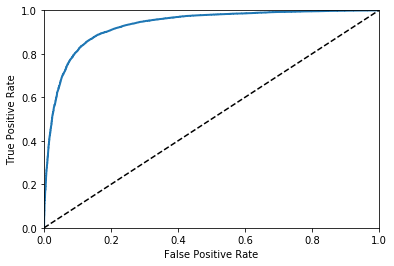

In [35]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr,tpr)
plt.show()

In [36]:
roc_auc_score(y_train_bin,y_scores)

0.93179866792375066

## K Nearest Neighbors

**K Nearest Neighbors (KNN)** is a non-parametric algorithm. KNN has been called a **lazy** learning algorithm due to the fact that it does not learn a discriminative function from the training data, but instead memorizes the data. These non-parametric algorithms cannot be characterized by a fixed set of parameters like logistic regression, but instead are characterized as the dataset grows in size.  An example of another non-parametric algorithm is random forests, which we will explore later. KNN belongs to a subset of non-parametric algorithms called **instance-based learners**.  

The biggest advantage of non-parametric, memory-based approaches, is the classifier's ability to adapt well to new training data.  

However, with non-parametric algorithms, computational complexity grows linearly with the size of the training data, leading to computationally expensive models.  It is also worth noting that KNN is susceptable to underforming in high-dimensionality datasets.

KNN runs based on the following steps:
    * Given a pre-selected number of K neighbors and specified distance metric:
        * Find the k nearest neighbors of the sample for classification
        * Assign the class label via majority vote.

**Hyperparameters explored:**
    * Number of k nearest neighbors (n_neighbors):
        * Choosing the right value for k is needed to balance overfitting and underfitting.
    * Weights (weights):
        * 

In [67]:
#GRID SEARCH WIP

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# parameters = {'clf__weights':['uniform','distance'],
#               'clf__n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


# knn_clf = GridSearchCV(knn_clf, param_grid=parameters, scoring='roc_auc',n_jobs=1,cv=10,verbose=10)

# knn_clf.best_params_
# {'clf__n_neighbors': 30, 'clf__weights': 'distance'}


knn_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', KNeighborsClassifier(n_neighbors=30,
                                                  weights='distance'))
])

knn_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='distance'))])

In [44]:
knn_clf.fit(X_train,y_train)
y_pred = knn_clf.predict(X_train)

In [46]:
print('Train Accuracy: %.3f' % knn_clf.score(X_train, y_train))

Train Accuracy: 0.991


#### Performance Metrics

We can see by the breakdown of class predictions, that the model has a harder time with the data science class, only correctly classifying 74% of predicted data science jobs.

In [59]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

data_science       0.80      0.78      0.79      2953
         mba       0.89      0.90      0.90      5800

 avg / total       0.86      0.86      0.86      8753



#### Confusion Matrix

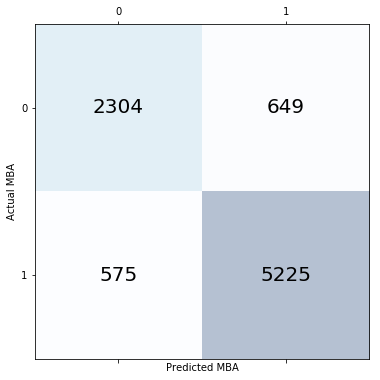

In [60]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fix, ax = plt.subplots(figsize=(6,8))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],
               va='center',ha='center',size=20)
plt.xlabel('Predicted MBA')
plt.ylabel('Actual MBA')
plt.show()

#### Precision/Recall Curve

In [61]:
y_probas_knn = cross_val_predict(knn_clf,X_train,y_train,cv=5,method='predict_proba')
y_scores_knn = y_probas_knn[:,1]
from sklearn.metrics import precision_recall_curve
y_train_bin = np.where(y_train=="mba",1,0)
precisions,recalls,thresholds = precision_recall_curve(y_train_bin,y_scores_knn)

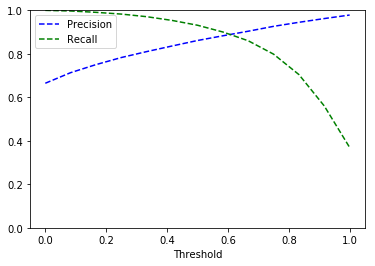

In [62]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

#### ROC Curve

In [63]:
from sklearn.metrics import roc_curve, auc

In [64]:
fpr,tpr,thresholds = roc_curve(y_train_bin,y_scores_knn,pos_label=1)

In [65]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

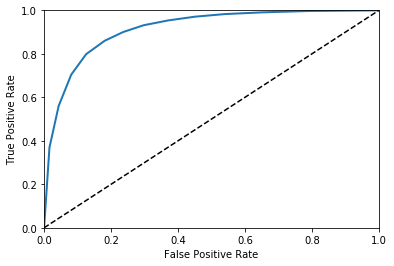

In [66]:
plot_roc_curve(fpr,tpr)
plt.show()

In [67]:
roc_auc_score(y_train_bin,y_scores_knn)

0.91420927120608586

## Naive Bayes

WIP - Gaussian?

Naive Bayes is a probalistic classifier.  It assumes "naively" assumed independence among the features and relies on ...

Naive Bayes assume that the value of a given feature is independent of the value of any other feature.

https://en.wikipedia.org/wiki/Naive_Bayes_classifier

**Hyperparameters explored:**
    * Alpha (alpha):
        

In [68]:
import sklearn         #added this line
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [167]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
nb_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB())
])

parameters = {'clf__alpha': [0.0001,0.001, 0.01, 0.1,1]}

nb_clf = GridSearchCV(nb_clf, param_grid=parameters, scoring='roc_auc',n_jobs=-1,cv=10,verbose=True)

In [171]:
nb_clf.fit(X_train, y_train)
print('Train Accuracy: %.3f' % nb_clf.score(X_train, y_train))
y_pred = nb_clf.predict(X_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.9s finished


Train Accuracy: 0.954


In [174]:
nb_clf.best_params_

{'clf__alpha': 0.1}

In [ ]:
#nb_clf.best_params_
#{'clf__alpha': 0.1}

In [172]:
nb_clf.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

#### Performance Metrics

In [173]:
from sklearn import metrics
print(metrics.classification_report(y_train,y_pred))

             precision    recall  f1-score   support

          0       0.89      0.83      0.86     12082
          1       0.89      0.93      0.91     18581

avg / total       0.89      0.89      0.89     30663



#### Confusion Matrix

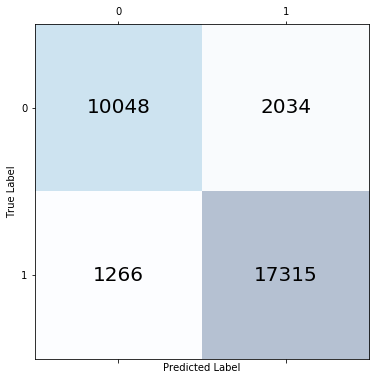

In [94]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_train, y_pred=y_pred)
fix, ax = plt.subplots(figsize=(6,8))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],
               va='center',ha='center',size=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Precision/Recall Curve

In [95]:
y_probas_nb = cross_val_predict(nb_clf,X_train,y_train,cv=10,method='predict_proba')
# y_probas_forest = cross_val_predict(forest_clf,X_train,y_train,cv=5,method="predict_proba")
y_scores_nb = y_probas_nb[:,1]
from sklearn.metrics import precision_recall_curve
# y_train_bin = np.where(y_train=="mba",1,0)
# precisions,recalls,thresholds = precision_recall_curve(y_train_bin,y_scores)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.9s finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   16.1s finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   16.0s finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.6s finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.7s finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.7s finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.6s finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.6s finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.5s finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.8s finished


In [96]:
y_train_bin = y_train
# y_train_bin = np.where(y_train=="mba",1,0)

In [97]:
precisions,recalls,thresholds = precision_recall_curve(y_train_bin,y_scores_nb)

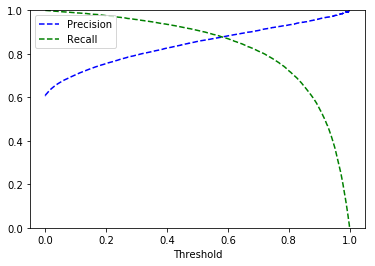

In [98]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

#### ROC Curve

In [99]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_predict
# y_scores = cross_val_predict(lr_clf,X_train,y_train,cv=5)
# y_scores = cross_val_predict(nb_clf,X_train,y_train,cv=5,method='decision_function')

In [100]:
# y_train_bin = np.where(y_train=="mba",1,0)
# y_scores_bin = np.where(y_scores=="mba",1,0)
fpr,tpr,thresholds = roc_curve(y_train_bin,y_scores_nb,pos_label=1)

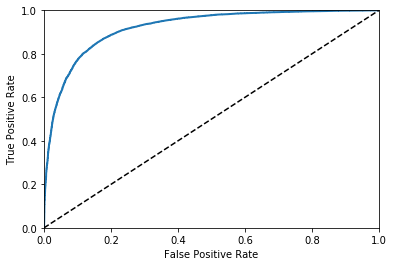

In [101]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr,tpr)
plt.show()

In [102]:
roc_auc_score(y_train_bin,y_scores_nb)

0.92091068075165561

## Support Vector Machine

**Support Vector Machine (SVM)** is an algorithm which can perform both linear and nonlinear classification. SVM seeks to find the widest possible margin or distance between the decision boundary of the distinct classes and the training samples themselves.  The balancing act in SVM is to keep the gulf between the classes as large as possible while simeltaneously limiting the number of samples that end up in the gulf.  This process is called **soft margin classification**. Decision boundaries with large margins tend to generalize better while those with small margins are more prone to overfitting.

Trained SVMs produce **support vectors** which can be thought of as an instance which is located within the gulf mentioned above.  These support vectors influence the decision boundary.  Additionally, model predictions are made using only these support vectors and not the entire training set.

#### Cost Penalization

Similar to how we implemented regularization with logistic regression, we can control the level of cost penalization with SVM, which in turn controls the width of the margin gulf.  This has the same effect of controlling the bias-variance tradeoff.



Use kernels on non-linear datasets.



**Hyperparameters explored:**
    * Pemalty for Misclassification (C):
        * A smaller C value leads to a wider gulf but more margin violations.  
        * A higher C value leads to a more narrow gulf with fewer margin volations.
    * Kernel:
        * rbf:
        * linear: The classes are linearly separable.  
        * poly: 

In [104]:
from sklearn.model_selection import GridSearchCV
# from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [105]:
svm_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SVC(probability=True,class_weight="balanced")),
])

parameters = {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'clf__kernel': ["rbf","linear","poly"]}

svm_clf = GridSearchCV(svm_clf, param_grid=parameters, scoring='roc_auc',n_jobs=-1,cv=10,verbose=True)

svm_clf.fit(X_train, y_train)
print('Test Accuracy: %.3f' % svm_clf.score(X_train, y_train))
y_pred = svm_clf.predict(X_train)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 136.3min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 737.3min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 900.6min finished


Test Accuracy: 0.965


In [106]:
svm_clf.best_params_

{'clf__C': 1, 'clf__kernel': 'linear'}

In [ ]:
#svm_clf.best_params_
#{'clf__C': 1, 'clf__kernel': 'linear'}

In [107]:
svm_clf.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

#### Performance Metrics

In [106]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred,
                       target_names=svm_clf.classes_))

              precision    recall  f1-score   support

data_science       0.00      0.00      0.00      3304
         mba       0.65      1.00      0.79      6102

 avg / total       0.42      0.65      0.51      9406



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Confusion Matrix

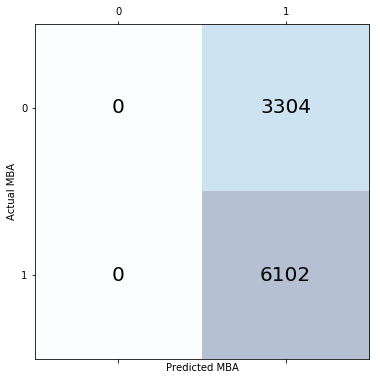

In [107]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fix, ax = plt.subplots(figsize=(6,8))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],
               va='center',ha='center',size=20)
plt.xlabel('Predicted MBA')
plt.ylabel('Actual MBA')
plt.show()

#### Precision/Recall Curve

In [108]:
y_scores = cross_val_predict(svm_clf,X_train,y_train,cv=5,method='decision_function')
from sklearn.metrics import precision_recall_curve
y_train_bin = np.where(y_train=="mba",1,0)
precisions,recalls,thresholds = precision_recall_curve(y_train_bin,y_scores)

KeyboardInterrupt: 

In [ ]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

#### ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_predict
# y_scores = cross_val_predict(lr_clf,X_train,y_train,cv=5)
y_scores = cross_val_predict(svm_clf,X_train,y_train,cv=5,method='decision_function')

In [ ]:
y_train_bin = np.where(y_train=="mba",1,0)
# y_scores_bin = np.where(y_scores=="mba",1,0)
fpr,tpr,thresholds = roc_curve(y_train_bin,y_scores,pos_label=1)

In [ ]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr,tpr)
plt.show()

In [ ]:
roc_auc_score(y_train_bin,y_scores)

In [43]:
# pipe_svc = Pipeline([('vect', CountVectorizer()),
#                       ('tfidf', TfidfTransformer()),
#                      ('clf',SVC(random_state=1))])

# param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# param_grid = [{'clf__C': param_range, 
#                'clf__kernel': ['linear']},
#                  {'clf__C': param_range, 
#                   'clf__gamma': param_range, 
#                   'clf__kernel': ['rbf']}]

# gs = GridSearchCV(estimator=pipe_svc, 
#                   param_grid=param_grid, 
#                   scoring='accuracy', 
#                   cv=10,
#                   n_jobs=-1)

# gs = gs.fit(X_train, y_train)
# print(gs.best_score_)
# print(gs.best_params_)

In [60]:
# clf = gs.best_estimator_
# clf.fit(X_train, y_train)
# print('Test accuracy: %.3f' % clf.score(X_test, y_test))

## Stochastic Gradient Descent

The Stochastic Gradient Descent (SGD) classifier can handle large datasets efficiently due to....

**Hyperparameters explored:**
    * Alpha (alpha):
    * Penalty (penalty):
    * Loss (loss):

In [178]:
from sklearn.linear_model import SGDClassifier
sgd_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(class_weight='balanced',
                                            n_jobs=-1,random_state=1))])

parameters = {'clf__alpha': [0.0001,0.001, 0.01, 0.1, 1],
             'clf__penalty': ['l2','l1','elasticnet'],
             'clf__loss': ['hinge', 'log']
}

sgd_clf = GridSearchCV(sgd_clf, param_grid=parameters, scoring='roc_auc',n_jobs=-1,cv=10,verbose=10)

In [179]:
sgd_clf.fit(X_train, y_train)
print('Train Accuracy: %.3f' % sgd_clf.score(X_train, y_train))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1 .............
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2, score=0.936460, total=   1

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s


[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1 .............
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2, score=0.938293, total=   1.8s
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2, score=0.929648, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1 .............
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2, score=0.933246, total=   1.8s
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2, score=0.931342, total=   1.9s
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1 .............
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2, score=0.930615, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1 .............
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1 .............
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2,

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.9s


[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1, score=0.926198, total=   1.9s
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet .....
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet .....
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l2, score=0.929098, total=   2.1s
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1, score=0.926523, total=   1.9s
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet .....
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet .....
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1, score=0.920972, total=   1.9s
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet .....
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1, score=0.918930, total=   1.8s
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1, score=0.919284, total=   1.7s
[CV] clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet .....
[CV] clf__loss=hinge, clf__alpha=0.0001,

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.4s


[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=l2 ...............
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=l1, score=0.917752, total=   2.0s
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet, score=0.934323, total=   1.9s
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=l2 ...............
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet, score=0.934223, total=   1.9s
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=l2 ...............
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=l2 ...............
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet, score=0.930663, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=l2 ...............
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet, score=0.928412, total=   2.0s
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=l2 ...............
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet, score=0.936563, total=   1.7s


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.5s


[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet, score=0.928275, total=   1.8s
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet, score=0.926459, total=   1.8s
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet, score=0.929752, total=   1.9s
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=l2 ...............
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=l2 ...............
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=l1 ...............
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=l2, score=0.934362, total=   1.8s
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=l2, score=0.933624, total=   1.7s
[CV]  clf__loss=hinge, clf__alpha=0.0001, clf__penalty=elasticnet, score=0.931328, total=   2.1s
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=l1 ...............
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=l2, score=0.928630, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=l1 ............

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.9s


[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=l2, score=0.927955, total=   1.9s
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=l1 ...............
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=l2, score=0.929867, total=   2.0s
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=elasticnet .......
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=l1, score=0.920733, total=   1.9s
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=l2, score=0.925855, total=   1.9s
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=elasticnet .......
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=elasticnet .......
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=l1, score=0.916455, total=   1.9s
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=l1, score=0.919734, total=   1.9s
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=l1, score=0.923096, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.0001, clf__penalty=elasticnet .......
[CV] clf__loss=log, clf__alpha=0.000

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.6s


[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=l1, score=0.914108, total=   1.7s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=l2 ..............
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=l1, score=0.911631, total=   2.0s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=l2 ..............
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=elasticnet, score=0.925560, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=l2 ..............
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=elasticnet, score=0.930854, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=l2 ..............
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=elasticnet, score=0.931368, total=   2.0s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=l2 ..............
[CV]  clf__loss=log, clf__alpha=0.0001, clf__penalty=elasticnet, score=0.924227, total=   2.1s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=l2 ..............
[CV]  clf__loss=log,

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.8s


[CV]  clf__loss=hinge, clf__alpha=0.001, clf__penalty=l2, score=0.923537, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=l1 ..............
[CV]  clf__loss=hinge, clf__alpha=0.001, clf__penalty=l2, score=0.917912, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=l1 ..............
[CV]  clf__loss=hinge, clf__alpha=0.001, clf__penalty=l2, score=0.925562, total=   1.7s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=l1 ..............
[CV]  clf__loss=hinge, clf__alpha=0.001, clf__penalty=l2, score=0.918047, total=   1.9s
[CV]  clf__loss=hinge, clf__alpha=0.001, clf__penalty=l2, score=0.913954, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=l1 ..............
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=l1 ..............
[CV]  clf__loss=hinge, clf__alpha=0.001, clf__penalty=l2, score=0.921829, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=l1 ..............
[CV]  clf__loss=hinge, clf__alpha=0.001, clf__

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.8s


[CV]  clf__loss=hinge, clf__alpha=0.001, clf__penalty=l1, score=0.896492, total=   1.9s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=elasticnet ......
[CV]  clf__loss=hinge, clf__alpha=0.001, clf__penalty=l1, score=0.886717, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=elasticnet ......
[CV]  clf__loss=hinge, clf__alpha=0.001, clf__penalty=l1, score=0.892651, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=elasticnet ......
[CV]  clf__loss=hinge, clf__alpha=0.001, clf__penalty=l1, score=0.888031, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.001, clf__penalty=elasticnet ......
[CV]  clf__loss=hinge, clf__alpha=0.001, clf__penalty=l1, score=0.880569, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.001, clf__penalty=l2 ................
[CV]  clf__loss=hinge, clf__alpha=0.001, clf__penalty=l1, score=0.879469, total=   1.9s
[CV] clf__loss=log, clf__alpha=0.001, clf__penalty=l2 ................
[CV]  clf__loss=hinge, clf__alpha=0.001, clf__

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   28.8s


[CV] clf__loss=log, clf__alpha=0.001, clf__penalty=l1 ................
[CV]  clf__loss=log, clf__alpha=0.001, clf__penalty=l2, score=0.919876, total=   2.0s
[CV] clf__loss=log, clf__alpha=0.001, clf__penalty=l1 ................
[CV]  clf__loss=log, clf__alpha=0.001, clf__penalty=l2, score=0.917370, total=   1.9s
[CV]  clf__loss=log, clf__alpha=0.001, clf__penalty=l2, score=0.912852, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.001, clf__penalty=l1 ................
[CV] clf__loss=log, clf__alpha=0.001, clf__penalty=l1 ................
[CV]  clf__loss=log, clf__alpha=0.001, clf__penalty=l2, score=0.912847, total=   2.0s
[CV] clf__loss=log, clf__alpha=0.001, clf__penalty=l1 ................
[CV]  clf__loss=log, clf__alpha=0.001, clf__penalty=l2, score=0.919447, total=   2.1s
[CV] clf__loss=log, clf__alpha=0.001, clf__penalty=l1 ................
[CV]  clf__loss=log, clf__alpha=0.001, clf__penalty=l2, score=0.908375, total=   2.0s
[CV] clf__loss=log, clf__alpha=0.001, clf__penalty=l1 ....

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   33.0s


[CV]  clf__loss=log, clf__alpha=0.001, clf__penalty=l1, score=0.876255, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.001, clf__penalty=elasticnet ........
[CV]  clf__loss=log, clf__alpha=0.001, clf__penalty=l1, score=0.881089, total=   2.0s
[CV] clf__loss=log, clf__alpha=0.001, clf__penalty=elasticnet ........
[CV]  clf__loss=log, clf__alpha=0.001, clf__penalty=l1, score=0.874510, total=   2.0s
[CV] clf__loss=log, clf__alpha=0.001, clf__penalty=elasticnet ........
[CV]  clf__loss=log, clf__alpha=0.001, clf__penalty=l1, score=0.869015, total=   1.9s
[CV] clf__loss=hinge, clf__alpha=0.01, clf__penalty=l2 ...............
[CV]  clf__loss=log, clf__alpha=0.001, clf__penalty=l1, score=0.870259, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.01, clf__penalty=l2 ...............
[CV]  clf__loss=log, clf__alpha=0.001, clf__penalty=elasticnet, score=0.910883, total=   1.9s
[CV] clf__loss=hinge, clf__alpha=0.01, clf__penalty=l2 ...............
[CV]  clf__loss=log, clf__alpha=0.001, clf__penalt

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   38.8s


[CV]  clf__loss=hinge, clf__alpha=0.01, clf__penalty=l2, score=0.898734, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.01, clf__penalty=l1 ...............
[CV]  clf__loss=hinge, clf__alpha=0.01, clf__penalty=l2, score=0.899639, total=   1.7s
[CV] clf__loss=hinge, clf__alpha=0.01, clf__penalty=l1 ...............
[CV]  clf__loss=hinge, clf__alpha=0.01, clf__penalty=l2, score=0.905567, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.01, clf__penalty=l1 ...............
[CV]  clf__loss=hinge, clf__alpha=0.01, clf__penalty=l2, score=0.894893, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.01, clf__penalty=l1 ...............
[CV]  clf__loss=hinge, clf__alpha=0.01, clf__penalty=l2, score=0.902496, total=   1.9s
[CV] clf__loss=hinge, clf__alpha=0.01, clf__penalty=l1 ...............
[CV]  clf__loss=hinge, clf__alpha=0.01, clf__penalty=l2, score=0.896905, total=   1.7s
[CV]  clf__loss=hinge, clf__alpha=0.01, clf__penalty=l2, score=0.906459, total=   1.9s
[CV] clf__loss=hinge, clf__alpha=0.0

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   43.5s


[CV]  clf__loss=hinge, clf__alpha=0.01, clf__penalty=elasticnet, score=0.887644, total=   1.8s
[CV]  clf__loss=hinge, clf__alpha=0.01, clf__penalty=l1, score=0.785793, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.01, clf__penalty=l2 .................
[CV] clf__loss=log, clf__alpha=0.01, clf__penalty=l2 .................
[CV]  clf__loss=hinge, clf__alpha=0.01, clf__penalty=elasticnet, score=0.881824, total=   1.9s
[CV] clf__loss=log, clf__alpha=0.01, clf__penalty=l2 .................
[CV]  clf__loss=hinge, clf__alpha=0.01, clf__penalty=elasticnet, score=0.884136, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.01, clf__penalty=l2 .................
[CV]  clf__loss=hinge, clf__alpha=0.01, clf__penalty=elasticnet, score=0.884139, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.01, clf__penalty=l2 .................
[CV]  clf__loss=hinge, clf__alpha=0.01, clf__penalty=elasticnet, score=0.889097, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.01, clf__penalty=l2 .................
[CV]  clf__l

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   49.0s


[CV]  clf__loss=log, clf__alpha=0.01, clf__penalty=l2, score=0.898418, total=   1.7s
[CV] clf__loss=log, clf__alpha=0.01, clf__penalty=l1 .................
[CV]  clf__loss=log, clf__alpha=0.01, clf__penalty=l2, score=0.903828, total=   2.0s
[CV] clf__loss=log, clf__alpha=0.01, clf__penalty=elasticnet .........
[CV]  clf__loss=log, clf__alpha=0.01, clf__penalty=l2, score=0.898475, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.01, clf__penalty=elasticnet .........
[CV]  clf__loss=log, clf__alpha=0.01, clf__penalty=l1, score=0.702023, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.01, clf__penalty=elasticnet .........
[CV]  clf__loss=log, clf__alpha=0.01, clf__penalty=l1, score=0.694893, total=   1.8s
[CV]  clf__loss=log, clf__alpha=0.01, clf__penalty=l1, score=0.705537, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.01, clf__penalty=elasticnet .........
[CV] clf__loss=log, clf__alpha=0.01, clf__penalty=elasticnet .........
[CV]  clf__loss=log, clf__alpha=0.01, clf__penalty=l1, score=0.7

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   54.4s


[CV] clf__loss=hinge, clf__alpha=0.1, clf__penalty=l1 ................
[CV]  clf__loss=log, clf__alpha=0.01, clf__penalty=elasticnet, score=0.863289, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.1, clf__penalty=l1 ................
[CV]  clf__loss=hinge, clf__alpha=0.1, clf__penalty=l2, score=0.903058, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.1, clf__penalty=l1 ................
[CV]  clf__loss=hinge, clf__alpha=0.1, clf__penalty=l2, score=0.899290, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.1, clf__penalty=l1 ................
[CV]  clf__loss=hinge, clf__alpha=0.1, clf__penalty=l2, score=0.896665, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.1, clf__penalty=l1 ................
[CV]  clf__loss=hinge, clf__alpha=0.1, clf__penalty=l2, score=0.898031, total=   1.9s
[CV] clf__loss=hinge, clf__alpha=0.1, clf__penalty=l1 ................
[CV]  clf__loss=hinge, clf__alpha=0.1, clf__penalty=l2, score=0.903321, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.1, clf__penalty=

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  1.0min


[CV]  clf__loss=hinge, clf__alpha=0.1, clf__penalty=l1, score=0.500000, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=0.1, clf__penalty=elasticnet ........
[CV]  clf__loss=hinge, clf__alpha=0.1, clf__penalty=l1, score=0.500000, total=   1.8s
[CV]  clf__loss=hinge, clf__alpha=0.1, clf__penalty=l1, score=0.500000, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.1, clf__penalty=l2 ..................
[CV]  clf__loss=hinge, clf__alpha=0.1, clf__penalty=elasticnet, score=0.694893, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.1, clf__penalty=l2 ..................
[CV] clf__loss=log, clf__alpha=0.1, clf__penalty=l2 ..................
[CV]  clf__loss=hinge, clf__alpha=0.1, clf__penalty=elasticnet, score=0.772857, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.1, clf__penalty=l2 ..................
[CV]  clf__loss=hinge, clf__alpha=0.1, clf__penalty=elasticnet, score=0.709890, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.1, clf__penalty=l2 ..................
[CV]  clf__loss=hinge, clf__alpha=

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  1.1min


[CV]  clf__loss=log, clf__alpha=0.1, clf__penalty=l2, score=0.894719, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.1, clf__penalty=elasticnet ..........
[CV]  clf__loss=log, clf__alpha=0.1, clf__penalty=l1, score=0.500000, total=   1.7s
[CV]  clf__loss=log, clf__alpha=0.1, clf__penalty=l1, score=0.500000, total=   2.0s
[CV] clf__loss=log, clf__alpha=0.1, clf__penalty=elasticnet ..........
[CV] clf__loss=log, clf__alpha=0.1, clf__penalty=elasticnet ..........
[CV]  clf__loss=log, clf__alpha=0.1, clf__penalty=l1, score=0.500000, total=   1.8s
[CV] clf__loss=log, clf__alpha=0.1, clf__penalty=elasticnet ..........
[CV]  clf__loss=log, clf__alpha=0.1, clf__penalty=l1, score=0.500000, total=   1.8s
[CV]  clf__loss=log, clf__alpha=0.1, clf__penalty=l1, score=0.500000, total=   2.0s
[CV] clf__loss=log, clf__alpha=0.1, clf__penalty=elasticnet ..........
[CV] clf__loss=log, clf__alpha=0.1, clf__penalty=elasticnet ..........
[CV]  clf__loss=log, clf__alpha=0.1, clf__penalty=l1, score=0.500000, 

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:  1.2min


[CV]  clf__loss=hinge, clf__alpha=1, clf__penalty=l2, score=0.899290, total=   1.9s
[CV]  clf__loss=hinge, clf__alpha=1, clf__penalty=l2, score=0.896665, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=1, clf__penalty=l1 ..................
[CV] clf__loss=hinge, clf__alpha=1, clf__penalty=l1 ..................
[CV]  clf__loss=hinge, clf__alpha=1, clf__penalty=l2, score=0.898031, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=1, clf__penalty=l1 ..................
[CV]  clf__loss=hinge, clf__alpha=1, clf__penalty=l2, score=0.903321, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=1, clf__penalty=l1 ..................
[CV]  clf__loss=hinge, clf__alpha=1, clf__penalty=l2, score=0.891119, total=   1.8s
[CV] clf__loss=hinge, clf__alpha=1, clf__penalty=l1 ..................
[CV]  clf__loss=hinge, clf__alpha=1, clf__penalty=l2, score=0.893601, total=   1.7s
[CV] clf__loss=hinge, clf__alpha=1, clf__penalty=l1 ..................
[CV]  clf__loss=hinge, clf__alpha=1, clf__penalty=l2, score=0.894515, 

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.3min


[CV]  clf__loss=hinge, clf__alpha=1, clf__penalty=elasticnet, score=0.500000, total=   1.9s
[CV] clf__loss=log, clf__alpha=1, clf__penalty=l2 ....................
[CV]  clf__loss=hinge, clf__alpha=1, clf__penalty=elasticnet, score=0.500000, total=   1.8s
[CV] clf__loss=log, clf__alpha=1, clf__penalty=l2 ....................
[CV]  clf__loss=hinge, clf__alpha=1, clf__penalty=elasticnet, score=0.500000, total=   1.9s
[CV] clf__loss=log, clf__alpha=1, clf__penalty=l2 ....................
[CV]  clf__loss=hinge, clf__alpha=1, clf__penalty=elasticnet, score=0.500000, total=   1.8s
[CV] clf__loss=log, clf__alpha=1, clf__penalty=l2 ....................
[CV]  clf__loss=hinge, clf__alpha=1, clf__penalty=elasticnet, score=0.500000, total=   1.9s
[CV] clf__loss=log, clf__alpha=1, clf__penalty=l1 ....................
[CV]  clf__loss=hinge, clf__alpha=1, clf__penalty=elasticnet, score=0.500000, total=   1.9s
[CV] clf__loss=log, clf__alpha=1, clf__penalty=l1 ....................
[CV]  clf__loss=log, c

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.5min finished


Train Accuracy: 0.952


In [180]:
sgd_clf.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...      penalty='l2', power_t=0.5, random_state=1, shuffle=True, verbose=0,
       warm_start=False))])

In [181]:
sgd_clf.best_params_

{'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'clf__penalty': 'l2'}

In [ ]:
# sgd_clf.best_params_
# {'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'clf__penalty': 'l2'}

In [ ]:
# sgd_clf.fit(X_train, y_train)

In [ ]:
# print('Test Accuracy: %.3f' % sgd_clf.score(X_test, y_test))

#### Performance Metrics

In [105]:
from sklearn import metrics
y_train_pred = sgd_clf.predict(X_train)
y_pred = sgd_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred,
                       target_names=sgd_clf.classes_))

              precision    recall  f1-score   support

data_science       0.91      0.65      0.76      1861
         mba       0.89      0.98      0.93      5276

 avg / total       0.89      0.89      0.88      7137



#### Confusion Matrix

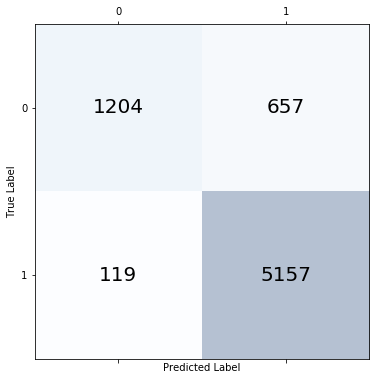

In [106]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fix, ax = plt.subplots(figsize=(6,8))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],
               va='center',ha='center',size=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Precision-Recall Curve

In [107]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train,cv=5,method='decision_function')

In [108]:
from sklearn.metrics import precision_recall_curve
y_train_bin = np.where(y_train=="mba",1,0)
precisions,recalls,thresholds = precision_recall_curve(y_train_bin,y_scores)

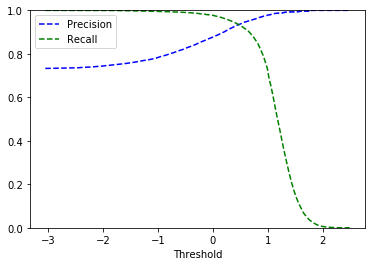

In [109]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

#### ROC Curve

In [110]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr,tpr,thresholds = roc_curve(y_train_bin,y_scores)

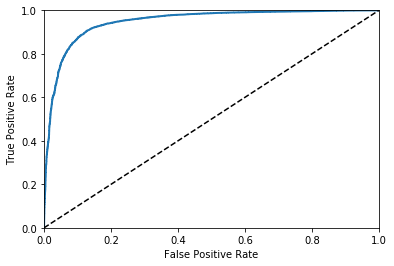

In [111]:
plot_roc_curve(fpr,tpr)
plt.show()

In [112]:
roc_auc_score(y_train_bin,y_scores)

0.94776300753975118

## Random Forests

Random forests fall under the 'ensemble' family of machine learning classifiers.  The model takes a random sample of observations as well as a random subset of features during training which it uses to build decision trees.  

**Hyperparameters explored**:
    * Tree size (n_estimators):
        * This parameter specifies the number of trees to be fitted in order to take the aggregate decision (max vote or average prediction).
        * Increasing the tree size will generally improve model accuracy but slow completion time.
    * Max Features (max_features):
        * This parameter specifies the maximum number of features the model uses in fitting individual trees.
        * Increasing the max features will typically improve model performance as a higher number of features are being used to fit at each decision node, however doing so will lower the diversity of the tree (and lead to overfitting).
        * The more features used, the longer the model will take to train.
        * Parameter Options include:
            * Use all features (Auto/None)
            * Use the square root of the number of features (sqrt)
            * Use the base log number of features (log2)
            * Use a specified percent of the number of features (0.X)
    * Minimum sample leaf (min_sample_leaf):
        * This parameter limits the minimum leaf (or end node) size of the decision tree.
        * Typically larger leaves capture less noise in the training data.
    * Decision criterion (criterion):
        * This parameter is the method by which predictions are made by our classifier.
            * Gini Index:
                * A measure of node purity.  Smaller values indicate node purity, larger values indicate node impurity.
                * For a split to take place, the Gini index for a child node should be less than that of the parent node.
            * Entropy:
                * A measure of node *impurity.* This value ranges between 0 and 1, where 0.5 indicates maximum impurity and the highest uncertainty of making a decision.

Depth parameter

In [182]:
from sklearn.ensemble import RandomForestClassifier
# forest_clf = RandomForestClassifier(random_state=42)
forest_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', RandomForestClassifier(class_weight='balanced',
                                                     random_state=1))])


parameters = {'clf__n_estimators': [10,50,100,500,1000],
             'clf__max_features': ["auto","sqrt","log2"],
             'clf__min_samples_leaf': [50,100,200,500],
             'clf__criterion': ['gini','entropy']}

forest_clf = GridSearchCV(forest_clf, param_grid=parameters, scoring='roc_auc',n_jobs=-1,cv=10,verbose=10)

In [183]:
forest_clf.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV] clf__min_samples_leaf=50, clf__max_features=auto

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s


[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.886812, total=   2.0s
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.867710, total=   2.0s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.877137, total=   2.1s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.896281, total=  

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.2s


[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.879416, total=   2.1s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50, score=0.907664, total=   3.0s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50, score=0.915019, total=   3.3s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50, score=0.907494, total=   3.0s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_esti

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.4s


[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50, score=0.902764, total=   3.4s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.910240, total=   4.4s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.916878, total=   4.2s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.912140, total=   4.5s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_e

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.0s


[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.910519, total=   4.4s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.908975, total=   4.6s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.906094, total=   4.7s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500, score=0.915572, total=  14.8s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.8s


[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500, score=0.910512, total=  15.2s
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500, score=0.913529, total=  15.6s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000 
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500, score=0.908387, total=  15.4s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.866271, total=   1.9s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   52.6s


[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000, score=0.918858, total=  28.4s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000, score=0.916889, total=  28.7s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.857005, total=   2.0s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.867273, total=   2.1s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf_

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.1min


[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50, score=0.888556, total=   2.8s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000, score=0.908130, total=  27.6s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50, score=0.897188, total=   2.8s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000, score=0.905445, total=  28.4s
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000, score=0.913955, total=  28.2s
[CV] clf__min_samples_leaf=100, clf__max_featur

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.3min


[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000, score=0.908502, total=  28.4s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.903323, total=   3.6s
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.905571, total=   3.6s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.897245, total=   3.5s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gin

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.5min


[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500, score=0.902931, total=  11.0s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.837990, total=   1.9s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.822626, total=   1.9s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.852350, total=   2.1s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.9min


[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50, score=0.888264, total=   2.5s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50, score=0.889477, total=   2.5s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50, score=0.872814, total=   2.4s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50, score=0.878751, total=   2.6s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=gini, clf__n

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  2.1min


[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.893454, total=   3.1s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.892153, total=   3.2s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.881852, total=   3.1s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.882761, total=   3.1s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini,

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.3min


[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500, score=0.890455, total=   8.4s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.767591, total=   1.8s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.735421, total=   1.8s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=10, score=0.757292, total=   1.9s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  2.6min


[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50, score=0.849925, total=   2.2s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000, score=0.890747, total=  13.8s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000, score=0.897769, total=  13.7s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000, score=0.891812, total=  13.4s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gin

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.8min


[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.845488, total=   2.5s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.836070, total=   2.5s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=100, score=0.857695, total=   2.5s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=500, score=0.879991, total=   5.3s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gin

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  3.1min


[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10, score=0.883409, total=   2.2s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10, score=0.867710, total=   2.0s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10, score=0.896281, total=   2.0s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=gini, clf__n_estimators=1000, score=0.884805, total=   9.3s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estim

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  3.3min


[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=50, score=0.902942, total=   3.1s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=50, score=0.902764, total=   3.1s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=100, score=0.910240, total=   4.3s
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=100, score=0.916878, total=   4.2s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=500 
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_es

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:  3.8min


[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10, score=0.883086, total=   2.0s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10, score=0.872828, total=   2.0s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10, score=0.857159, total=   2.0s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10, score=0.883677, total=   2.0s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  4.3min


[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=1000, score=0.905445, total=  27.4s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=100, score=0.907359, total=   3.6s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=1000, score=0.915010, total=  27.5s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=1000, score=0.916365, total=  27.2s
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=100, score=0.906011, total=   3.6s
[CV] clf__min_samples_leaf=100, clf__max_feat

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:  4.6min


[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=500, score=0.902931, total=  10.9s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10, score=0.837990, total=   2.1s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10, score=0.822626, total=   1.9s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10, score=0.852350, total=   2.0s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf__

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:  5.1min


[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=1000, score=0.908960, total=  19.8s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=1000, score=0.901431, total=  19.8s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=1000, score=0.908639, total=  20.8s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=50, score=0.867113, total=   2.5s
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=1000, score=0.901906, total=  19.9s
[CV] clf__min_samples_leaf=200, clf__max_f

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.5min


[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10, score=0.735421, total=   1.8s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10, score=0.757292, total=   2.1s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10, score=0.729279, total=   1.9s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=1000, score=0.904106, total=  13.7s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=gini, clf_

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:  5.8min


[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=50, score=0.810660, total=   2.2s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=50, score=0.852087, total=   2.1s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=100, score=0.833411, total=   2.6s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=100, score=0.854717, total=   2.4s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, 

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  6.2min


[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=10, score=0.595139, total=   1.8s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=10, score=0.542482, total=   1.7s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=1000, score=0.876698, total=   8.9s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=gini, clf__n_estimators=1000, score=0.884805, total=   9.3s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_es

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.4min


[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=100, score=0.820986, total=   2.5s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=100, score=0.833030, total=   2.3s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=100, score=0.788124, total=   2.3s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=500, score=0.878325, total=   4.6s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n

[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  6.8min


[CV] clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=50, score=0.708261, total=   2.2s
[CV] clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=1000, score=0.883364, total=   7.4s
[CV] clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=1000, score=0.903434, total=   7.7s
[CV] clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=1000, score=0.889101, total=   7.3s
[CV] clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=gini, c

[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  7.1min


[CV]  clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=500, score=0.871115, total=   4.4s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=500, score=0.848350, total=   4.9s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=10, score=0.604836, total=   2.0s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=10, score=0.499238, total=   2.5s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=gini, clf_

[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:  7.5min


[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=100, score=0.730292, total=   2.4s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=100, score=0.741025, total=   2.3s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=100, score=0.672248, total=   2.3s
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=100, score=0.724418, total=   2.5s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=500 
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini

[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:  7.9min


[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=1000, score=0.864103, total=   7.5s
[CV] clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=10, score=0.535780, total=   1.8s
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=1000, score=0.847806, total=   7.1s
[CV] clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=1000, score=0.860894, total=   7.2s
[CV] clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=50 
[CV] clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=gini, 

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  8.2min


[CV]  clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=500, score=0.769553, total=   4.9s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10, score=0.888776, total=   2.3s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10, score=0.896938, total=   2.2s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=gini, clf__n_estimators=1000, score=0.804505, total=   6.9s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=log2, clf__criteri

[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  8.6min


[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100, score=0.902931, total=   5.2s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100, score=0.911349, total=   5.1s
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100, score=0.908050, total=   5.2s
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100, score=0.913890, total=   4.9s
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500 
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500 
[CV] clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf_

[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=50, score=0.905525, total=   2.8s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=50, score=0.889802, total=   2.8s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100 


[Parallel(n_jobs=-1)]: Done 661 tasks      | elapsed:  9.6min


[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=50, score=0.895012, total=   3.1s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=1000, score=0.914145, total=  33.1s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100, score=0.905894, total=   4.0s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100, score=0.908644, total=   3.9s
[CV] clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=aut

[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10, score=0.851535, total=   2.0s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10, score=0.836614, total=   2.0s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10 


[Parallel(n_jobs=-1)]: Done 698 tasks      | elapsed: 10.3min


[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=1000, score=0.912108, total=  23.7s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=100, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=1000, score=0.912161, total=  23.8s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10, score=0.840359, total=   1.9s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10, score=0.848714, total=   2.0s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto,

[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500, score=0.892989, total=   8.4s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500, score=0.896719, total=   8.6s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500, score=0.900977, total=   8.7s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500, score=0.891315, total=   8.5s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=1000 


[Parallel(n_jobs=-1)]: Done 737 tasks      | elapsed: 10.9min


[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500, score=0.901092, total=   8.6s
[CV] clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500, score=0.893739, total=   9.1s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500, score=0.894857, total=   8.6s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10, score=0.767591, total=   1.9s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto

[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100, score=0.878039, total=   2.4s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100, score=0.864278, total=   2.6s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100, score=0.852383, total=   2.5s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100, score=0.845249, total=   2.5s
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100, score=0.863729, total=   2.6s
[CV] clf__min_samples

[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 11.3min


[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100, score=0.855236, total=   2.7s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=100, score=0.856632, total=   2.5s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500, score=0.880854, total=   5.4s
[CV] clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=500, clf__max_features=auto, clf__criterion=entropy, clf__n_estimators=500, score=0.880748, total=   5.7s
[CV] clf__min_samples_leaf=500, clf__max_features

[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.906949, total=   3.5s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.905333, total=   3.4s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.900049, total=   3.5s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.908440, total=   3.5s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__crit

[Parallel(n_jobs=-1)]: Done 817 tasks      | elapsed: 11.9min


[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.903351, total=   3.4s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.902757, total=   3.5s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=100, score=0.918372, total=   4.8s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=100, score=0.906656, total=   4.8s
[CV] clf__min_samples_leaf=50, clf__max_features=sqrt, clf__cr

[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.901366, total=   2.8s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.903106, total=   2.8s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.895204, total=   2.9s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.896923, total=   2.9s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf_

[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 12.9min


[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.905525, total=   2.8s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.889802, total=   2.8s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.895012, total=   2.9s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=100, score=0.905894, total=   4.0s
[CV] clf__min_samples_leaf=100, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=50, clf__max_features=sqrt,

[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10, score=0.850783, total=   2.0s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10, score=0.856382, total=   1.9s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10, score=0.851535, total=   1.9s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10, score=0.836614, total=   1.9s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=100, clf__max_features=sqrt, clf

[Parallel(n_jobs=-1)]: Done 901 tasks      | elapsed: 13.7min


[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10, score=0.848714, total=   1.9s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.887010, total=   2.4s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.879250, total=   2.5s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50, score=0.884462, total=   2.4s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf

[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=1000 
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=500, score=0.900977, total=   8.8s
[CV] clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=500, score=0.901092, total=   8.5s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=500, score=0.893739, total=   9.0s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, c

[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed: 14.4min


[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=1000, score=0.904240, total=  15.5s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=200, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=1000, score=0.901710, total=  15.2s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10, score=0.775615, total=   2.0s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10, score=0.832306, total=   1.9s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt,

[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=100, score=0.856632, total=   2.5s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=500, score=0.880748, total=   5.5s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=500, score=0.882635, total=   5.5s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=500, score=0.880854, total=   5.5s
[CV] clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=500, clf__max_featur

[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 14.9min


[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=500, score=0.872168, total=   5.6s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=10, score=0.619444, total=   1.9s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=10, score=0.623035, total=   1.9s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__criterion=entropy, clf__n_estimators=1000, score=0.885847, total=   9.2s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=10 
[CV]  clf__min_samples_leaf=500, clf__max_features=sqrt, clf__c

[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500 
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100, score=0.806402, total=   2.3s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100, score=0.797081, total=   2.5s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100, score=0.820807, total=   2.4s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_esti

[Parallel(n_jobs=-1)]: Done 1034 tasks      | elapsed: 15.4min


[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500, score=0.897069, total=   4.7s
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500, score=0.887828, total=   4.8s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500, score=0.881092, total=   4.9s
[CV] clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=50, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500, score=0.876062, total=   4.6s
[CV] clf__min_samples_leaf=100, clf__max_features=log2, 

[CV] clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100, score=0.763971, total=   2.2s
[CV] clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100, score=0.742796, total=   2.3s
[CV] clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100, score=0.770527, total=   2.2s
[CV] clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100, score=0.753302, total=   2.6s
[CV] clf__min_samples_leaf=100, clf__max_features=lo

[Parallel(n_jobs=-1)]: Done 1081 tasks      | elapsed: 15.9min


[CV]  clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500, score=0.871059, total=   4.6s
[CV]  clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500, score=0.845357, total=   4.4s
[CV] clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV] clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500, score=0.852142, total=   4.6s
[CV] clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500, score=0.871064, total=   4.6s
[CV]  clf__min_samples_leaf=100, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500, score=0.843463, total=   4.7s
[CV] clf__min_samp

[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=50, score=0.651613, total=   2.1s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=50, score=0.587596, total=   2.1s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=50, score=0.650101, total=   2.1s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100, score=0.730129, total=   2.4s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2

[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 16.3min


[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100, score=0.695857, total=   2.4s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500, score=0.829875, total=   4.5s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500, score=0.813770, total=   4.5s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500, score=0.830535, total=   4.5s
[CV] clf__min_samples_leaf=200, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=200, clf__max_featur

[CV]  clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=50, score=0.585946, total=   2.0s
[CV] clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=50, score=0.648661, total=   2.1s
[CV] clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=50, score=0.559661, total=   2.2s
[CV] clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=50, score=0.622728, total=   2.0s
[CV] clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=500, clf__max_features=log2,

[Parallel(n_jobs=-1)]: Done 1177 tasks      | elapsed: 16.8min


[CV]  clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100, score=0.593786, total=   2.2s
[CV] clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500 
[CV]  clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100, score=0.543336, total=   2.5s
[CV] clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=100, score=0.642040, total=   2.3s
[CV] clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=500, score=0.740002, total=   4.4s
[CV] clf__min_samples_leaf=500, clf__max_features=log2, clf__criterion=entropy, clf__n_estimators=1000 
[CV]  clf__min_samples_leaf=500, clf__max_feature

[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 17.2min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__min_samples_leaf': [50, 100, 200, 500], 'clf__max_features': ['auto', 'sqrt', 'log2'], 'clf__criterion': ['gini', 'entropy'], 'clf__n_estimators': [10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=10)

In [184]:
print('Train Accuracy: %.3f' % forest_clf.score(X_train, y_train))
y_pred = forest_clf.predict(X_train)

Train Accuracy: 0.921


In [185]:
forest_clf.best_params_

{'clf__criterion': 'entropy',
 'clf__max_features': 'auto',
 'clf__min_samples_leaf': 50,
 'clf__n_estimators': 1000}

In [ ]:
# forest_clf.best_params_
# {'clf__criterion': 'entropy',
#  'clf__max_features': 'auto',
#  'clf__min_samples_leaf': 50,
#  'clf__n_estimators': 1000}

In [186]:
forest_clf.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...timators=1000, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))])

#### Performance Metrics

In [116]:
from sklearn import metrics
y_train_pred = forest_clf.predict(X_train)
y_pred = forest_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred,
                       target_names=sgd_clf.classes_))

              precision    recall  f1-score   support

data_science       0.88      0.83      0.85      1861
         mba       0.94      0.96      0.95      5276

 avg / total       0.92      0.92      0.92      7137



#### Confusion Matrix

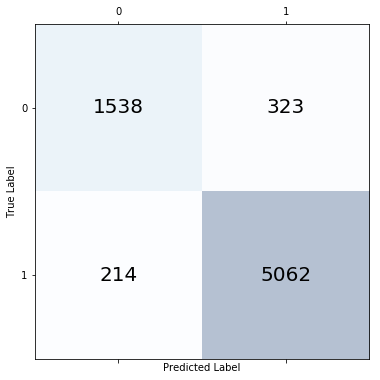

In [117]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fix, ax = plt.subplots(figsize=(6,8))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],
               va='center',ha='center',size=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Precision-Recall Curve

In [118]:
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train,cv=5,method="predict_proba")
y_scores_forest = y_probas_forest[:,1]

In [119]:
from sklearn.metrics import precision_recall_curve
y_train_bin = np.where(y_train=="mba",1,0)
precisions,recalls,thresholds = precision_recall_curve(y_train_bin,y_scores_forest)

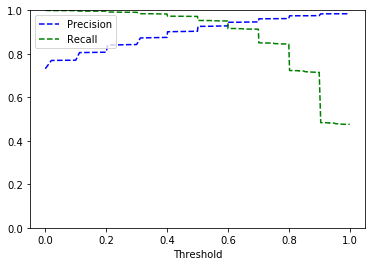

In [120]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

#### ROC Curve

In [121]:
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_bin,y_scores_forest)

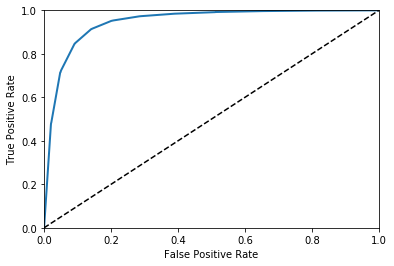

In [122]:
plot_roc_curve(fpr_forest,tpr_forest)
plt.show()

In [123]:
roc_auc_score(y_train_bin,y_scores_forest)

0.94573923706369523

# Learning Ensembles

In machine learning, it is possible to aggregate the predictions or classifications from a group of models and create new, hopefully superior performing 'ensemble' model. One can take a variety of very different types of models, like the ones we explored above. In fact, it is often better if the underlying models in an ensemble are quite different in nature as a more diverse set of learning is used and the lower the chance that they will make the same types of errors. Even if an individual classifer is weak on its own, it can contribute to a much stronger performing model through ensembling.

We will perform this ensembling by training and tuning the following types of ensemble models:
* Voting Classifier
* Adaboost Classifier
* Gradient Boosting Classifier
* Stacking Classifier

## Voting Classifier

A voting classifer aggregates the predictions or classifications of various underlying classifiers and makes its prediction based on the class that gets the most votes.

There are two types of voting classifiers:
* Hard Voting:
  * Counts the votes of each classifier in the ensemble and selects the class that receives the most votes.
* Soft Voting:
  * Calculates the average estimated class probability for each class and chooses the class with the highest probability.
  * This approach often produces better results, however it only works if all classifiers in the ensemble can produce class probabilities.  In our case, all classifiers can estimate class probabilities, so we will explore this voting option.

One of the most interesting aspects of Voting Classifiers is the fact that we can find optimal values of the hyperparameters of our individual models to achieve the best performance.  While we already tuned our individual models' hyperparameters, we will once again utilize grid search in our voting classifier to see if we can make further performance gains.


In [124]:
from sklearn.ensemble import VotingClassifier

In [159]:
voting_clf = Pipeline([('clf', VotingClassifier(estimators=[('lr',lr_clf),('knn',knn_clf),
                                                            ('nb',nb_clf),('svm',svm_clf),('sgd',sgd_clf),
                                                              ('rf',forest_clf)],voting="soft"))])
voting_clf.fit(X_train,y_train)

Pipeline(steps=[('clf', VotingClassifier(estimators=[('lr', Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, st...mators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]))],
         n_jobs=1, voting='soft', weights=None))])

In [160]:
print('Test Accuracy: %.3f' % voting_clf.score(X_test, y_test))

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [148]:
from sklearn.metrics import accuracy_score
for clf in (lr_clf,knn_clf,nb_clf,svm_clf,sgd_clf,forest_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(clf,accuracy_score(y_test,y_pred))
#     print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]) 0.923217037971
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...owski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform'))]) 0.903180608099
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='

#### Performance Metrics

In [154]:
from sklearn import metrics
y_train_pred = voting_clf.predict(X_train)
y_pred = voting_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred,
                       target_names=voting_clf.classes_))

              precision    recall  f1-score   support

data_science       0.91      0.82      0.86      1861
         mba       0.94      0.97      0.95      5276

 avg / total       0.93      0.93      0.93      7137



#### Confusion Matrix

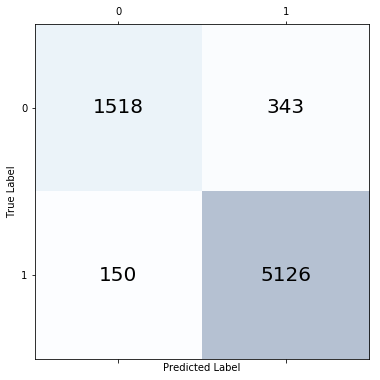

In [155]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fix, ax = plt.subplots(figsize=(6,8))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],
               va='center',ha='center',size=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Precision/Recall Curve

In [158]:
y_probas_voting = cross_val_predict(voting_clf,X_train,y_train,cv=5,method="predict_proba")
y_scores_voting = y_probas_voting[:,1]

AttributeError: 'VotingClassifier' object has no attribute 'decision_function'

In [ ]:
from sklearn.metrics import precision_recall_curve
y_train_bin = np.where(y_train=="mba",1,0)
precisions,recalls,thresholds = precision_recall_curve(y_train_bin,y_scores_voting)

#### ROC Curve

## Adaboost

With Adaboost, the mistakes of various individual classifiers are used to improve the performance of the next classifier.  

First a classifier is trained and fitted and the relative weights of misclassified training instances is increased thereby forcing the model to pay more attention to the cases which the prior model underfitted.

Then a second classifier is trained using the updated weights and the cycle repeats.

Learning Rate:
* If our Adaboost ensemble underfits the training data, we can try increasing the learning rate.

## Gradient Boosting

Similar to Adaboost, Gradient Boosting iterively fits individual models and changes accordingly.

Instead of updating weights based on misclassifications like Adaboost, Gradient Boosting attempts to fit the next classifier to the residual errors of the predeceding model.

**Hyperparameters explored:**
    * Learning Rate:
        * The learning_rate is a hyper-parameter in the range (0.0, 1.0] that controls overfitting via shrinkage
        * If our Adaboost ensemble underfits the training data, we can try increasing the learning rate.

    * Early Stopping:
        * This is used to find the right number of predictors.

# Exploring the Worst Predictions

In this section, we will use the predictions from our best classifier (logistic regression with 5-fold cross validation) to find the descriptions which the model most narrowly classified.

In [ ]:
#export predictions
prediction_probs = pd.DataFrame(text_clf.predict_proba(descriptions_train))
prediction_probs.columns = text_clf.classes_

from matplotlib import pyplot as plt

plt.figure(figsize=(18,10))

x = prediction_probs['data_science']
y = prediction_probs['mba']

bins = np.linspace(0, 1, 100)

plt.hist(x, bins, alpha=0.5, label='data_science')
plt.hist(y, bins, alpha=0.5, label='mba')
plt.legend(loc='upper right',prop={'size':20})
plt.xticks(np.arange(0, 1, 0.1))
plt.show()

If you group the probabilities into ranges, we can see that around 6% of our data lie within the most indecisive probability intervals (45%-55%).  Within these two ranges, only 56% and 47% of predictions were correct.  These are the most inaccurate of our predictions and therefore the hardest to classify within our two categories.

In [ ]:
prediction_probs['predicted'] = np.where(prediction_probs['data_science']>
                                        prediction_probs['mba'],"data_science","mba")
prediction_probs['actual'] = pd.DataFrame(categories_train).reset_index()['category']
prediction_probs['correct'] = np.where(prediction_probs['predicted']==
                                        prediction_probs['actual'],1,np.NaN)
prob_dist = (pd.DataFrame(prediction_probs
                          .groupby(pd.cut(prediction_probs["data_science"], 
                   np.arange(0, 1.05, .05),include_lowest=True))
                          .agg({"data_science":"count",
                               "correct":"sum"})))
prob_dist.columns = ["count_correct","count"]
prob_dist['pct'] = prob_dist['count']/len(prediction_probs)
prob_dist['pct_correct'] = prob_dist['count_correct']/prob_dist['count']
prob_dist.reset_index(inplace=True)
prob_dist.columns = ["probability_interval","count_correct","count","pct","pct_correct"]

In [ ]:
prob_dist

### View Misclassified Descriptions

In [ ]:
df_predicted_wrong_all = pd.concat([df_predicted_wrong_gs,
                             df_predicted_wrong_lr,
                             df_predicted_wrong_nb,
                             df_predicted_wrong_svm])

In [ ]:
df_predicted_wrong_all.drop_duplicates(keep='last',inplace=True)

In [ ]:
df_predicted_wrong_all.shape